In [78]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [79]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"",",None
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"",",None
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {...",None
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...,None
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r...",None


In [80]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [81]:
rejected_male = data[data['contrib_gender'] == 'male']
rejected_female = data[data['contrib_gender'] == 'female']

rejected_male = rejected_male[rejected_male['merged_or_not'] == 0]
rejected_female = rejected_female[rejected_female['merged_or_not'] == 0]

print("rejected_male: ", rejected_male.shape[0])
print("rejected_female: ", rejected_female.shape[0])


rejected_male:  7739
rejected_female:  822


In [82]:
data = data.loc[data['contrib_gender'].notna()]

In [83]:
data.shape

(60206, 142)

In [84]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [85]:
data = data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [86]:
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [87]:
data.drop(contributor_characteristics, axis=1, inplace=True)
data.drop(project_characteristics, axis=1, inplace=True)
data.drop(unable_to_control, axis=1, inplace=True)
data.drop(['pull_request_id', 'first_closer_id', 'last_closer_id'], axis=1, inplace=True)
data.drop(['mergetime_minutes'], axis=1, inplace=True)

In [88]:
data.shape

(60206, 75)

In [89]:
gender_dict = {'male': 0, 'female': 1}

data['contrib_gender'] = data['contrib_gender'].map(gender_dict)
df_majority = data[data['contrib_gender']==0]
df_minority = data[data['contrib_gender']==1]

df_majority_downsampled = df_majority.sample(len(df_minority), replace=False)

data = pd.concat([df_majority_downsampled, df_minority])
print(data['contrib_gender'].value_counts())

contrib_gender
0    5873
1    5873
Name: count, dtype: int64


In [90]:
encoders = { }
for column in data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(data[column])
    data[column] = le_col.transform(data[column])
    encoders[column] = le_col

In [91]:
normalization_not_required = ['contrib_gender', 'merged_or_not', 'perc_external_contribs', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'requester_succ_rate', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'perc_contrib_neg_emo', 'perc_contrib_pos_emo', 'perc_contrib_neu_emo', 'perc_inte_neg_emo', 'perc_inte_pos_emo', 'perc_inte_neu_emo']

In [92]:
data['part_num_code'].value_counts()

part_num_code
0     9146
2     1201
1      792
3      411
4      121
5       47
6       15
7        8
10       2
12       1
8        1
9        1
Name: count, dtype: int64

In [93]:
data['contrib_gender'].value_counts

<bound method IndexOpsMixin.value_counts of 48053    0
34526    0
15446    0
24232    0
36306    0
        ..
75846    1
75863    1
75874    1
75881    1
75885    1
Name: contrib_gender, Length: 11746, dtype: int64>

In [94]:
import numpy as np

columns_to_normalize = [col for col in data.columns if col not in normalization_not_required]

data[columns_to_normalize] = data[columns_to_normalize].apply(lambda x: np.log1p(x))

/opt/miniconda3/envs/pytorch2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


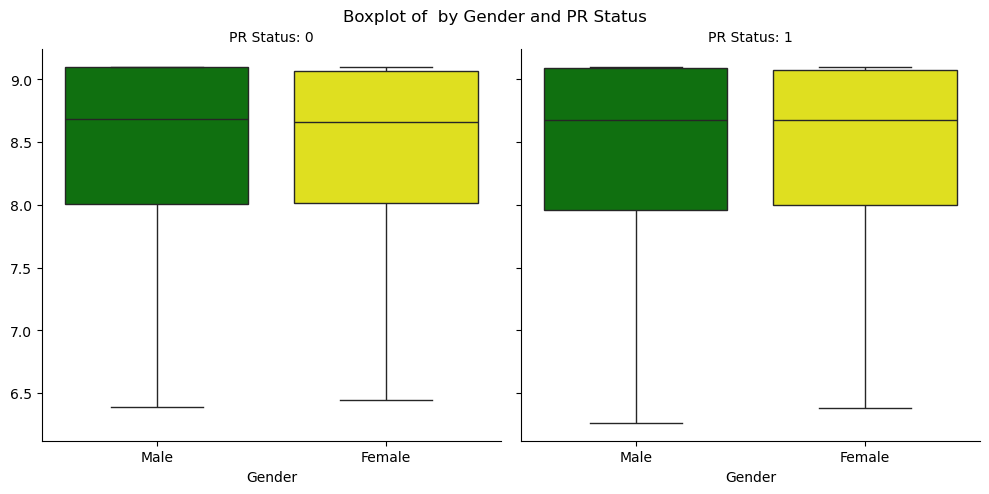

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


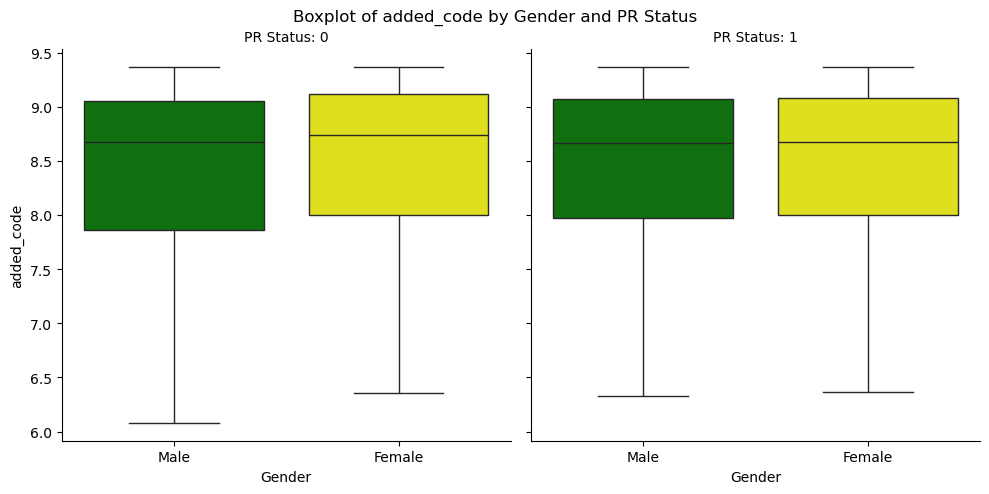

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


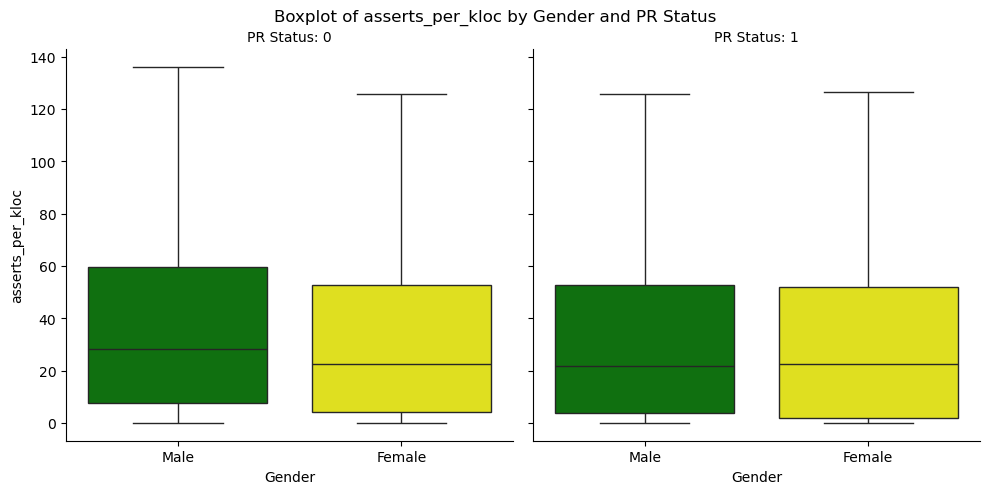

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


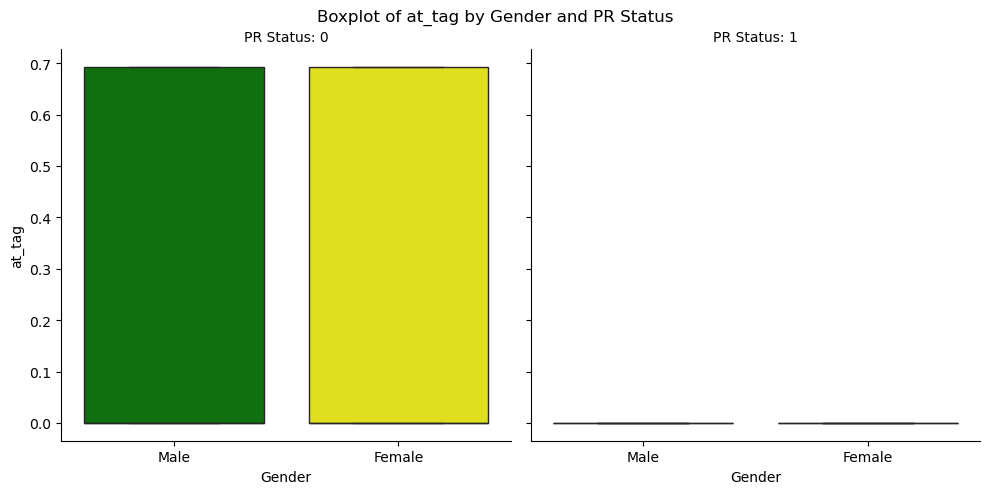

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


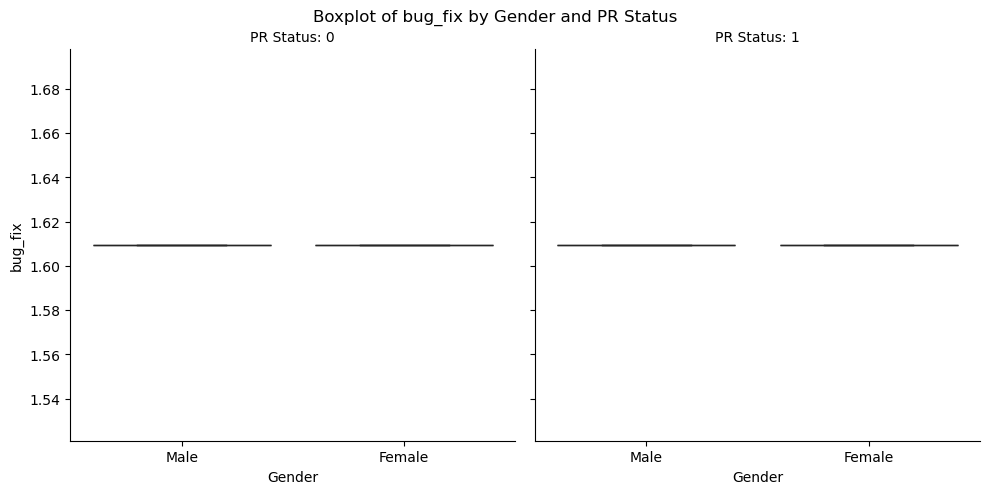

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


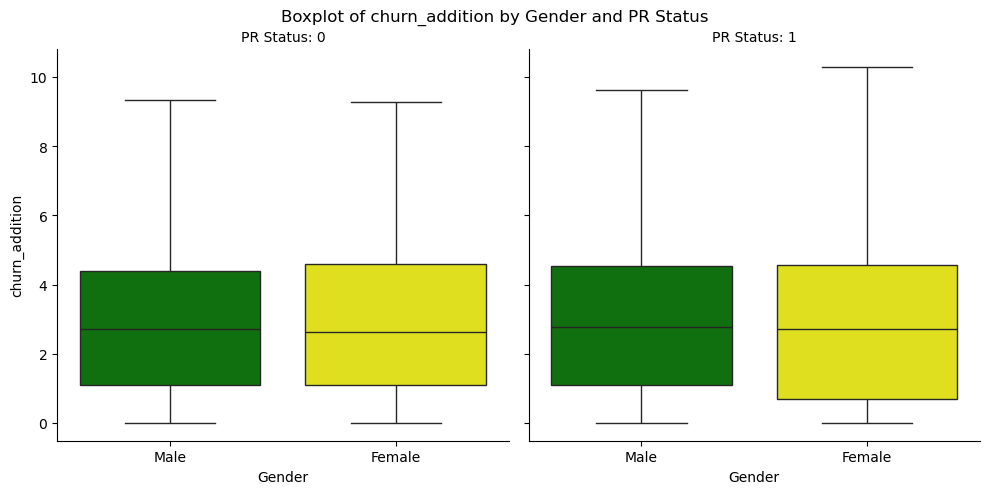

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


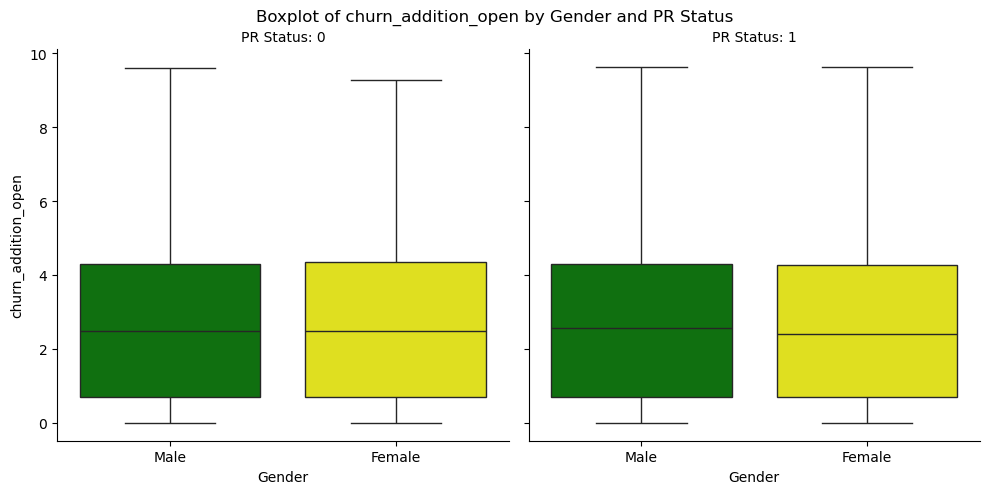

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


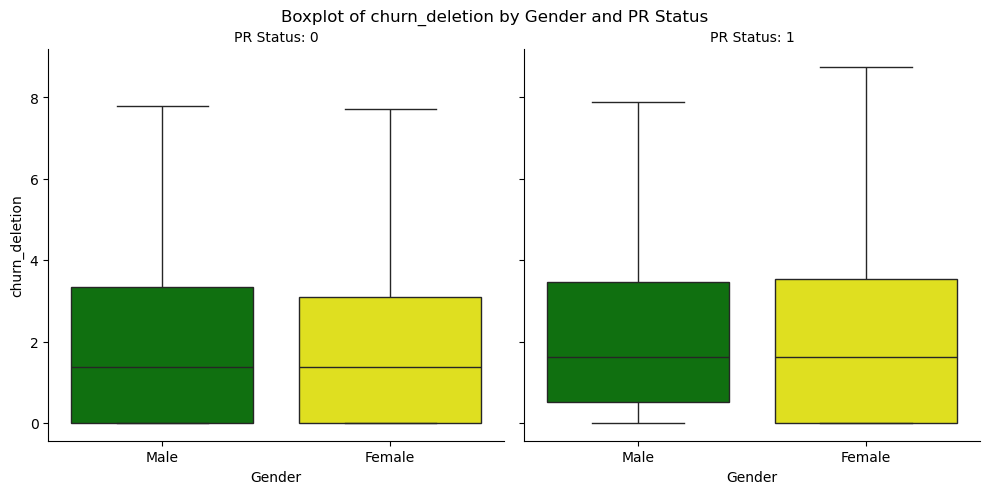

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


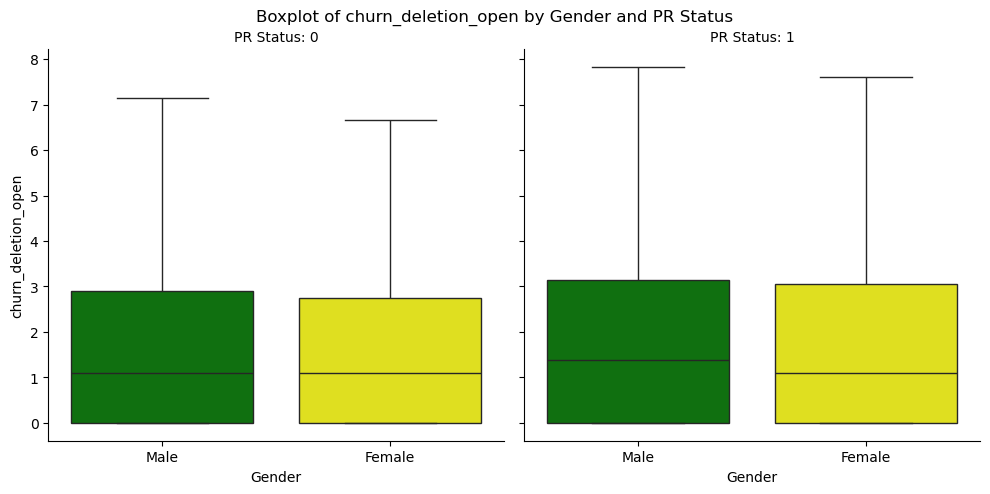

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


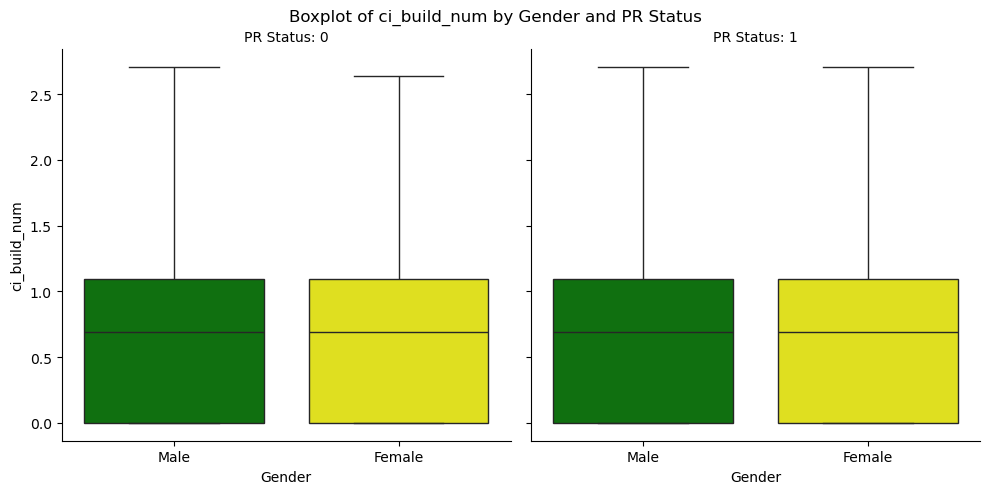

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


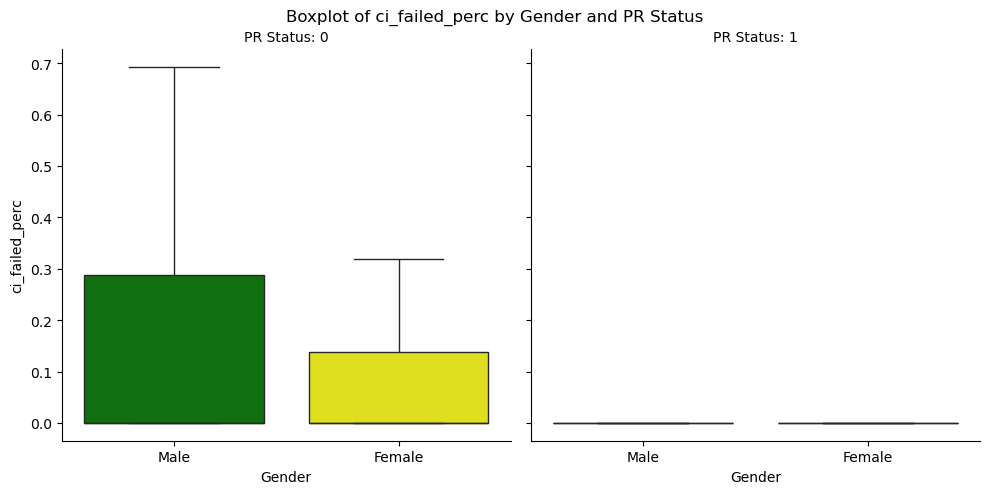

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


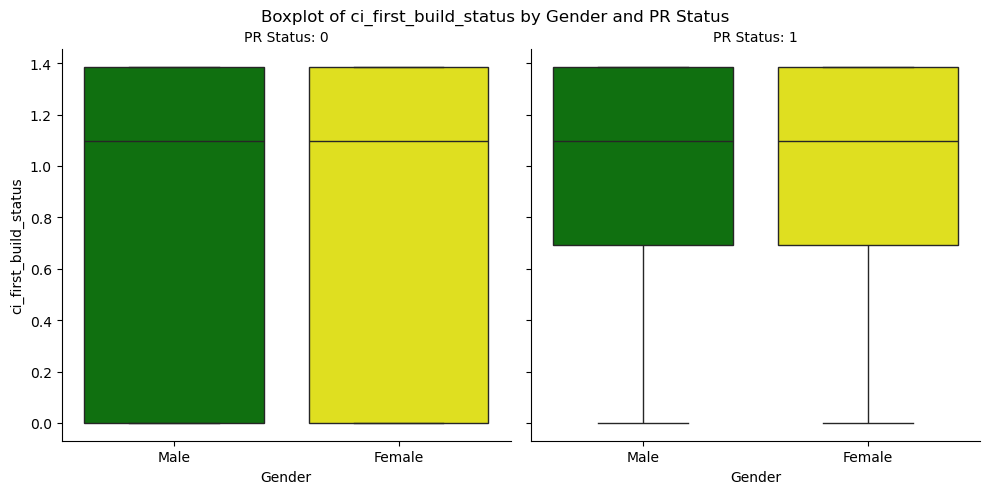

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


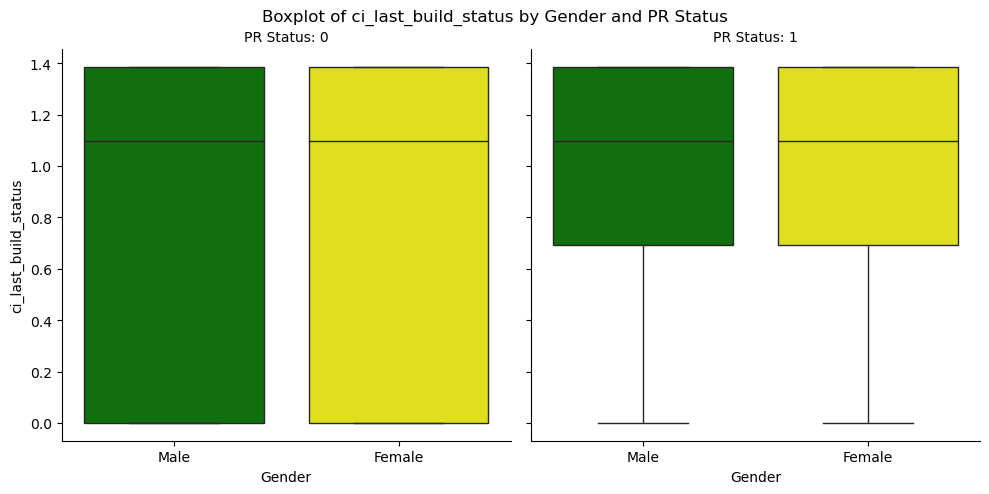

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


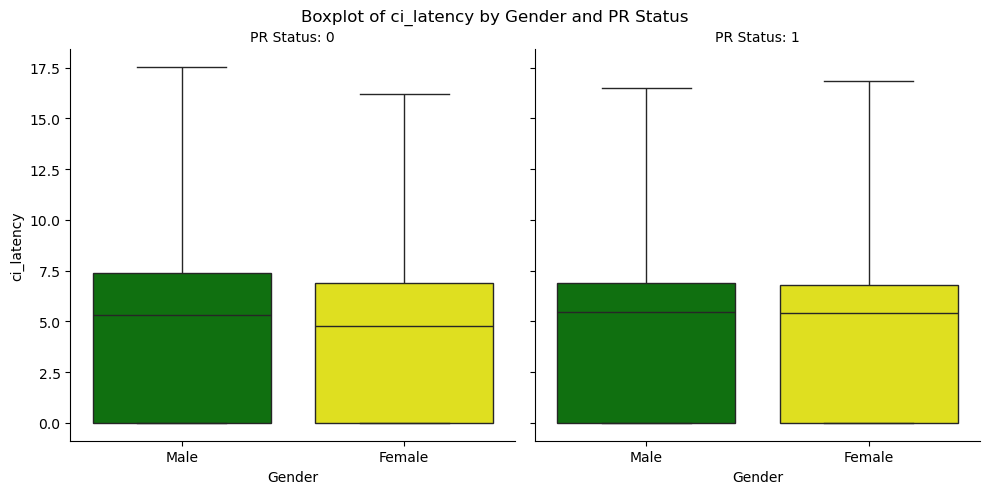

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


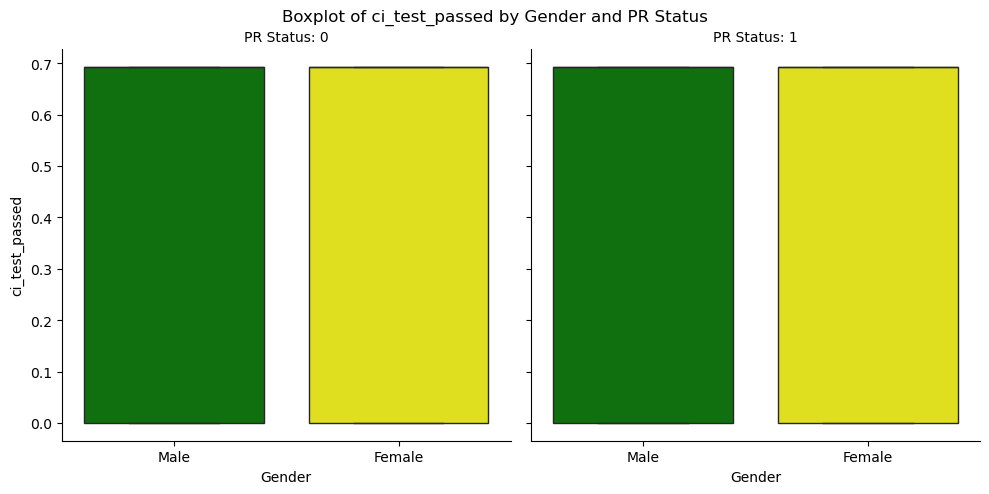

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


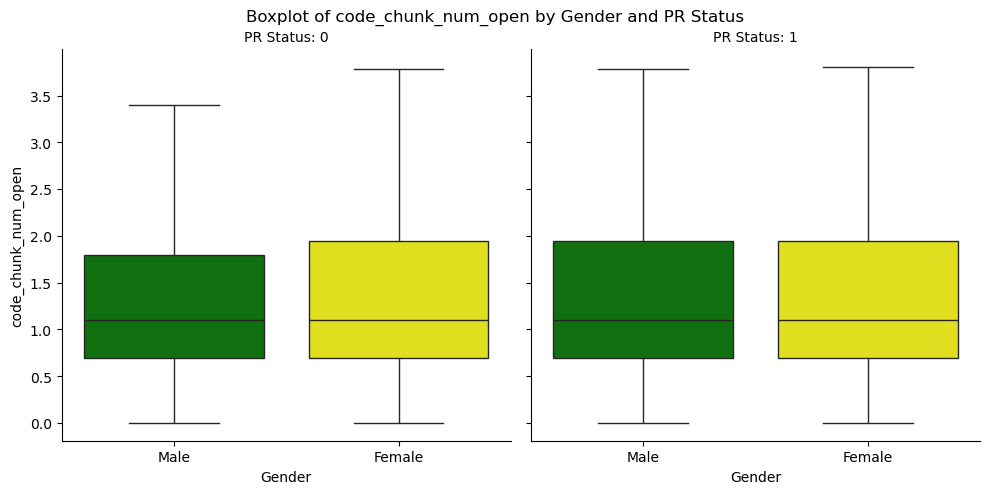

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


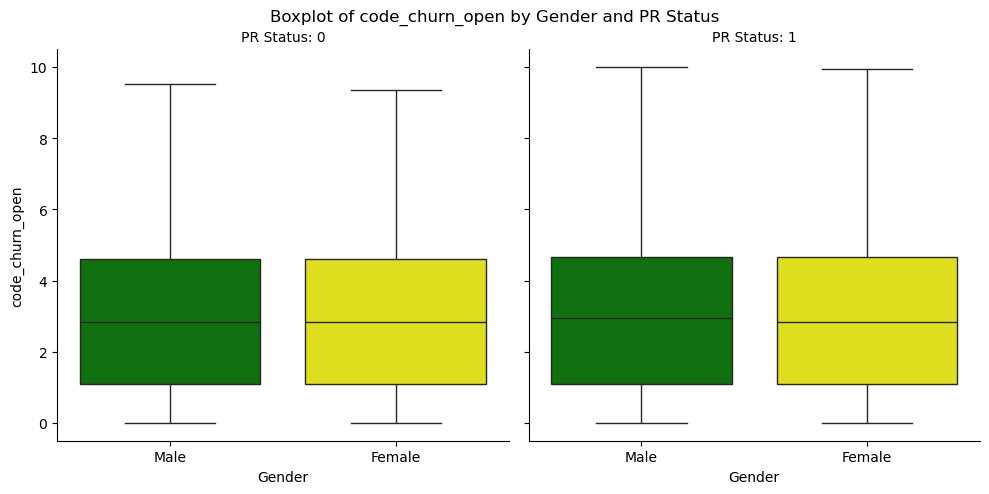

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


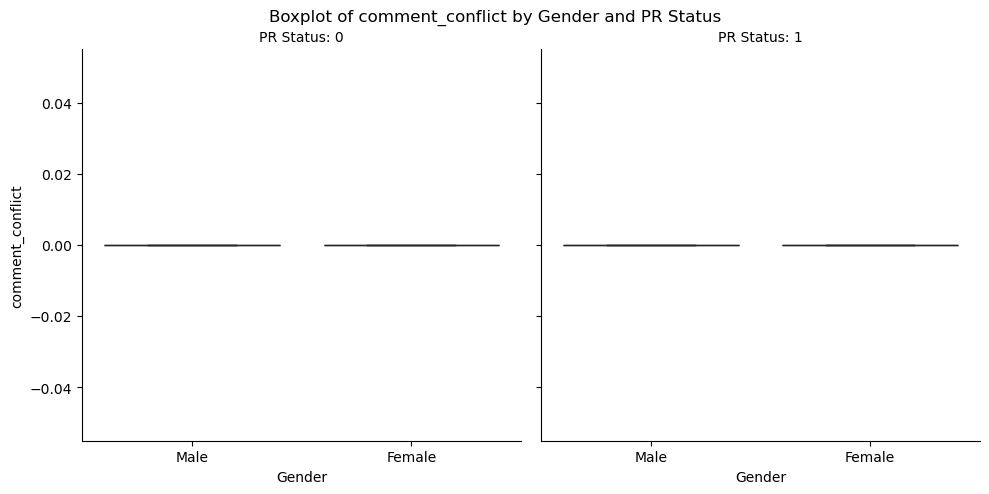

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


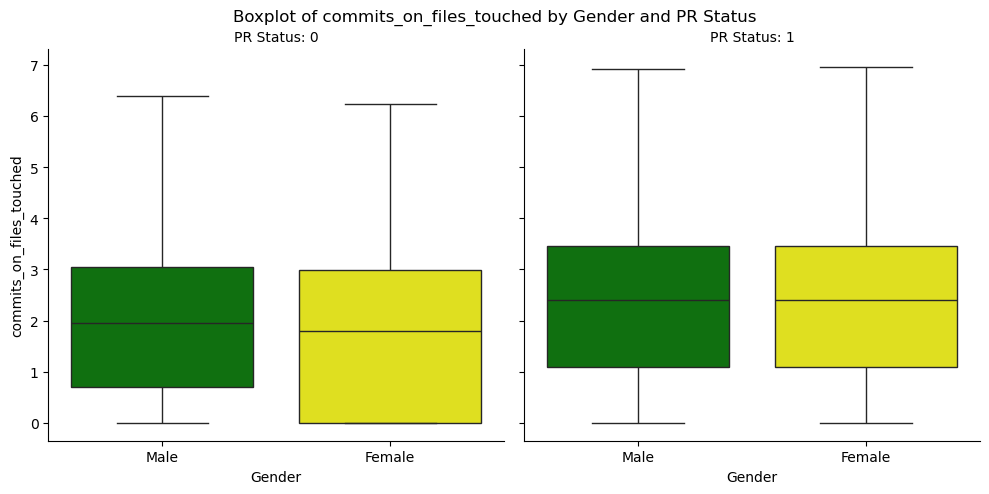

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


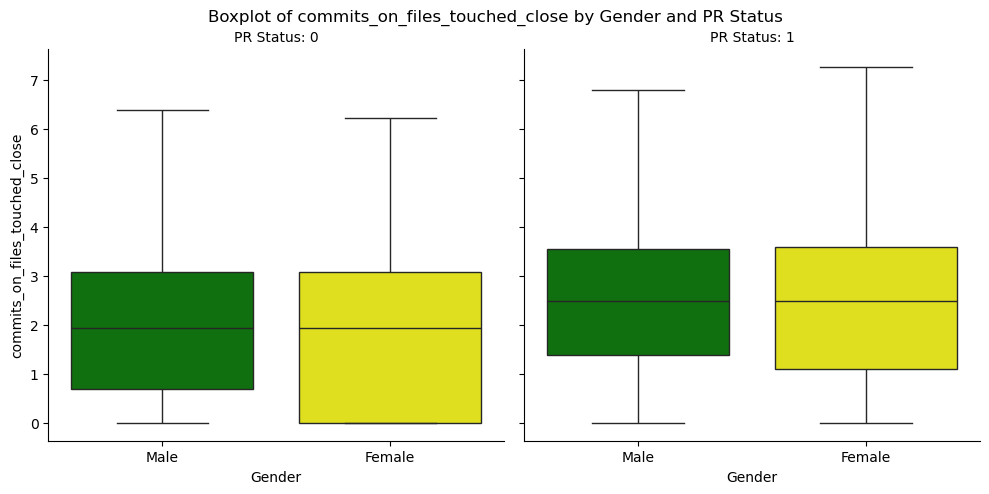

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


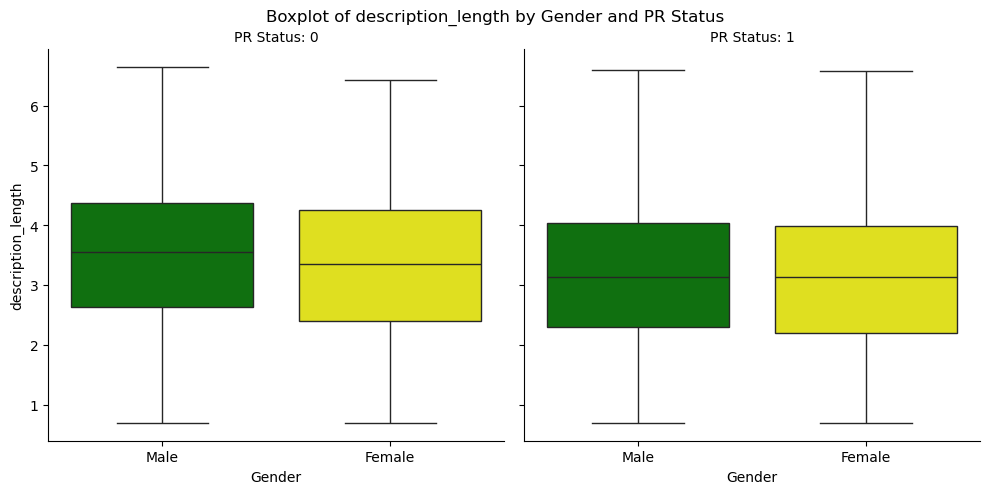

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


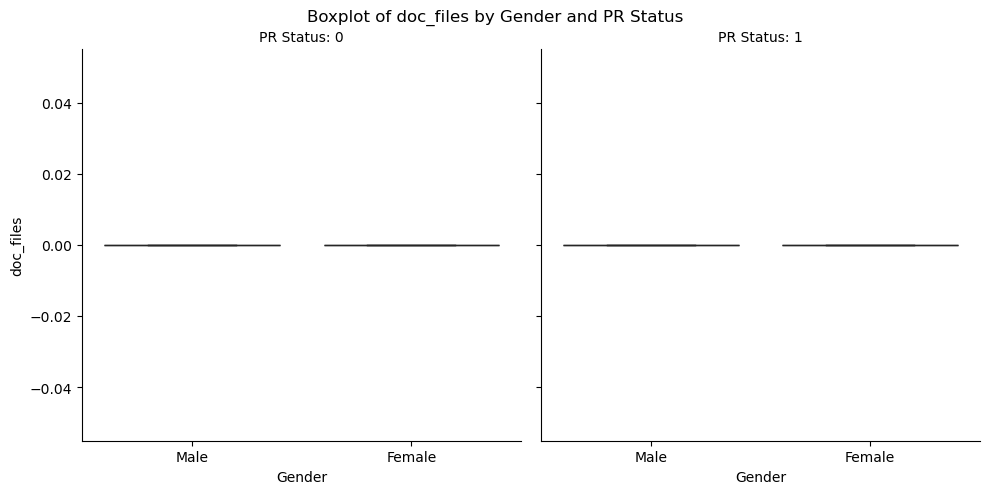

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


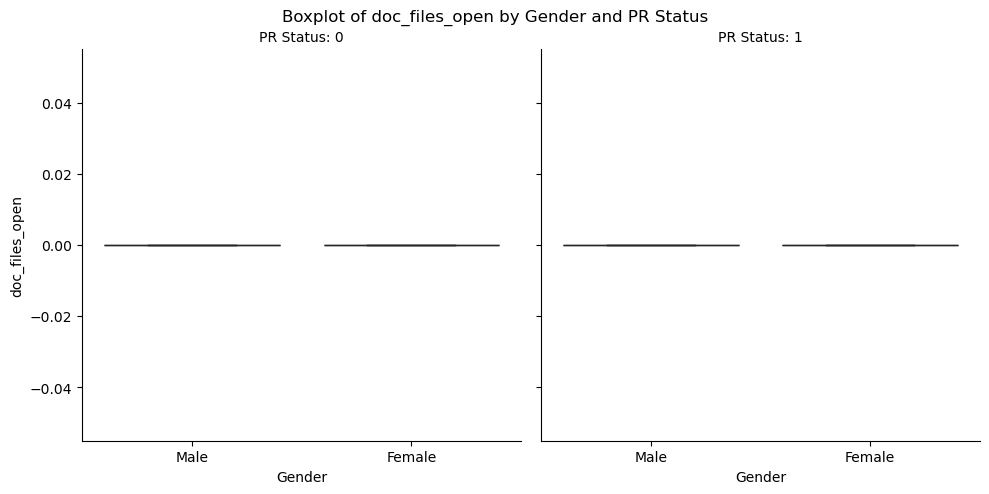

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


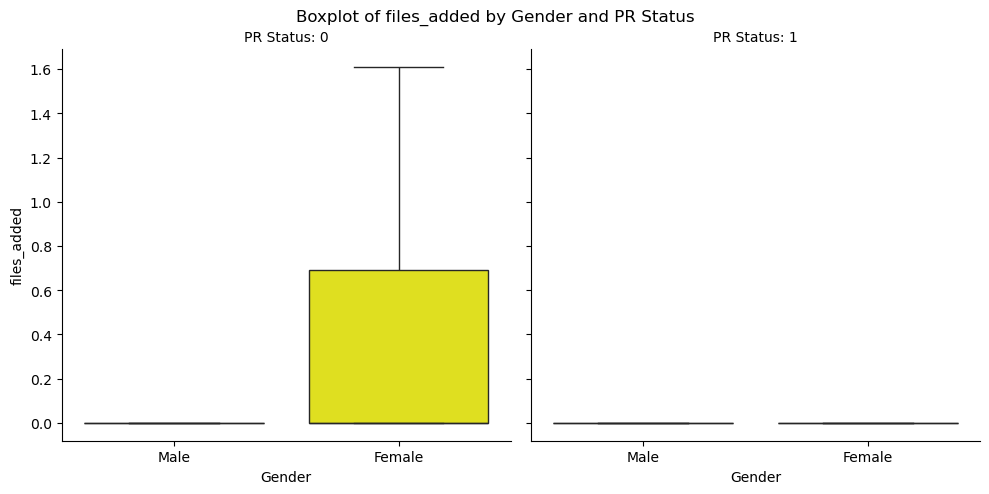

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


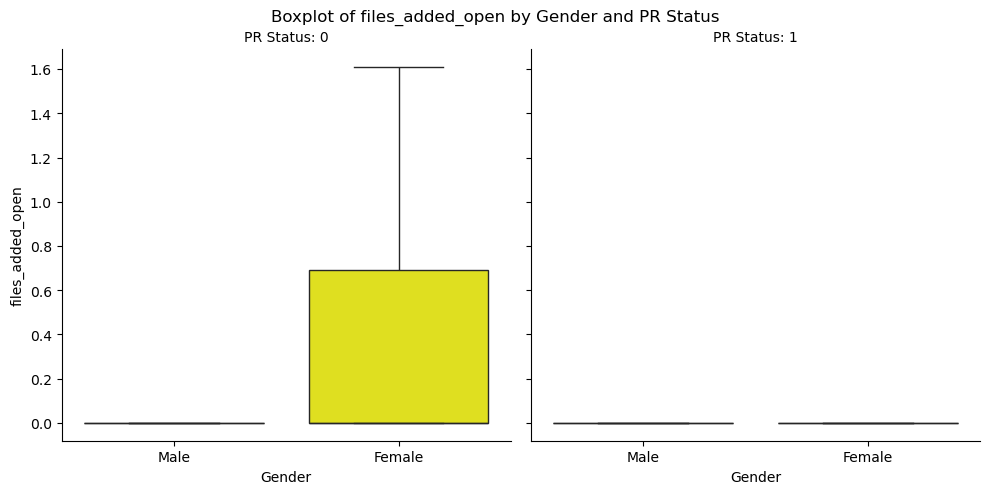

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


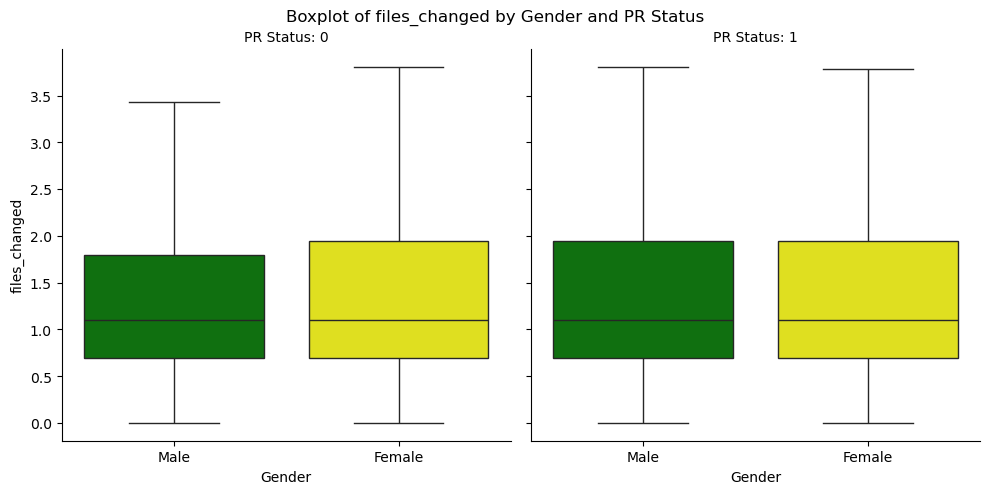

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


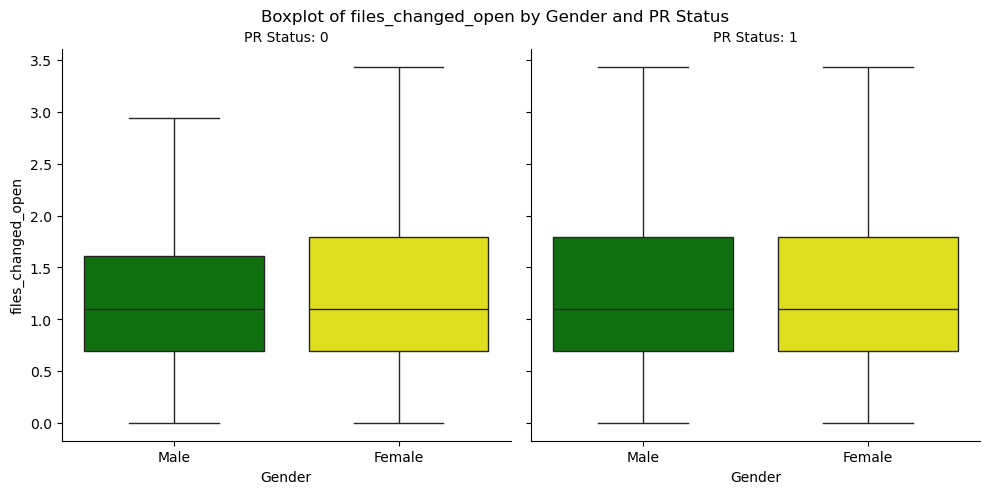

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


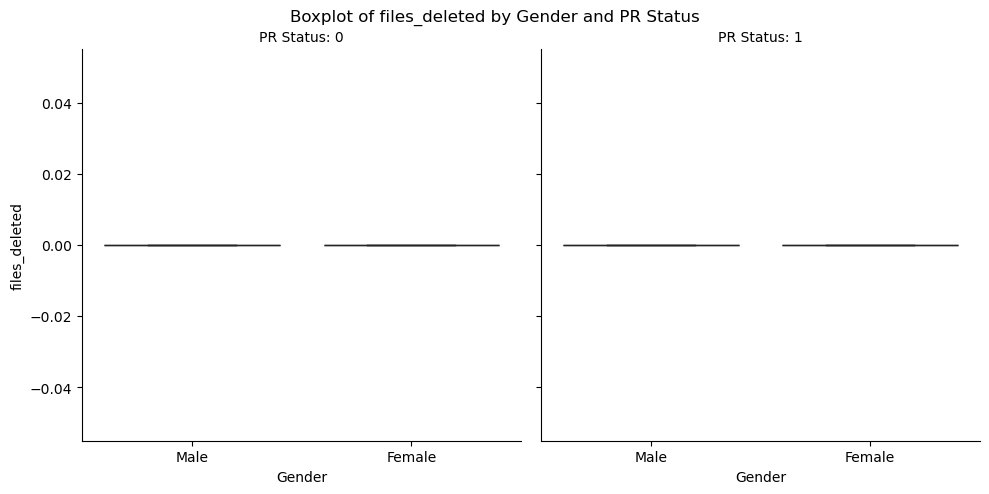

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


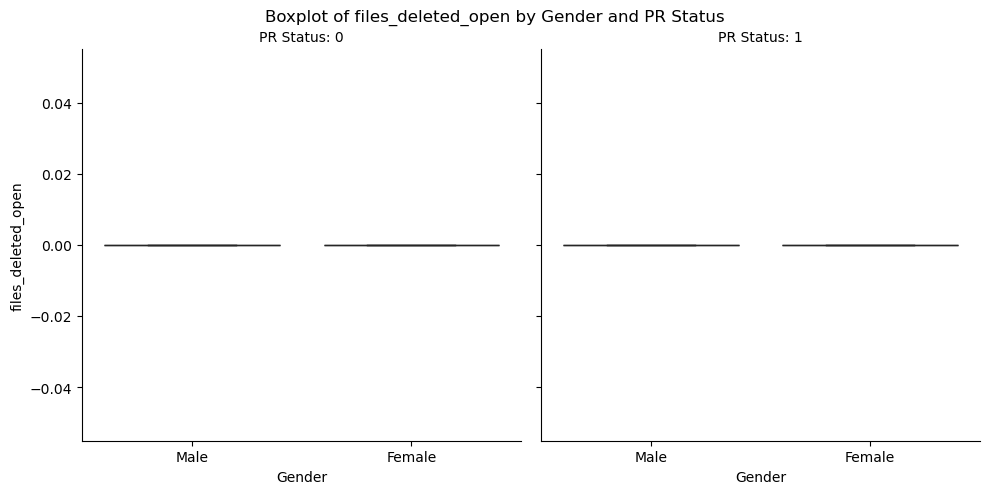

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


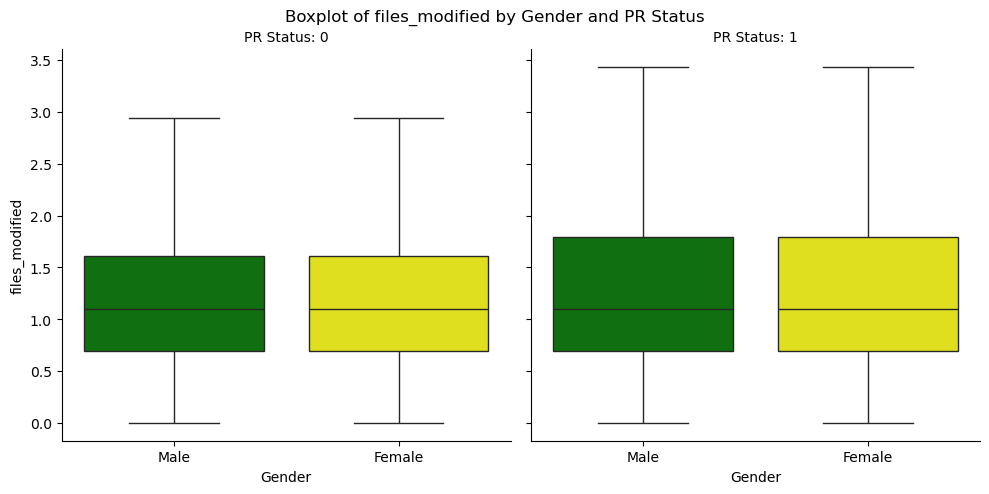

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


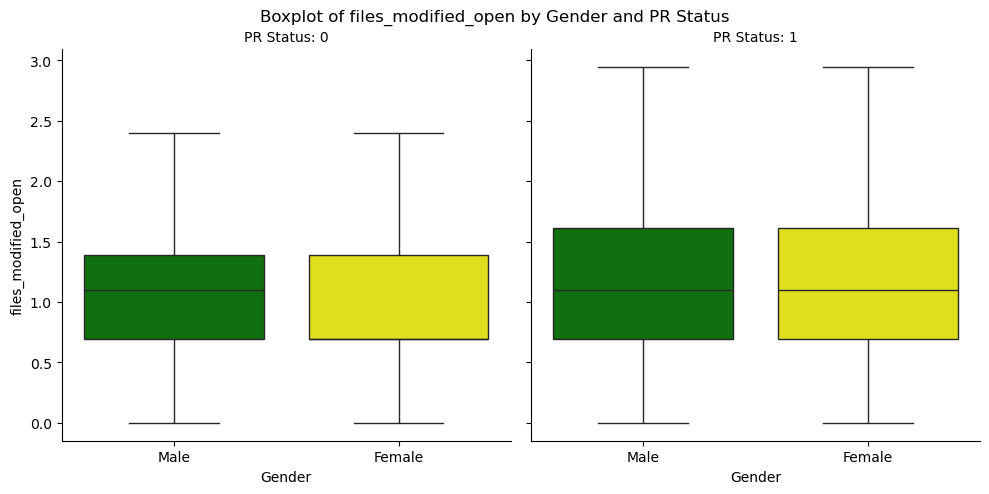

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


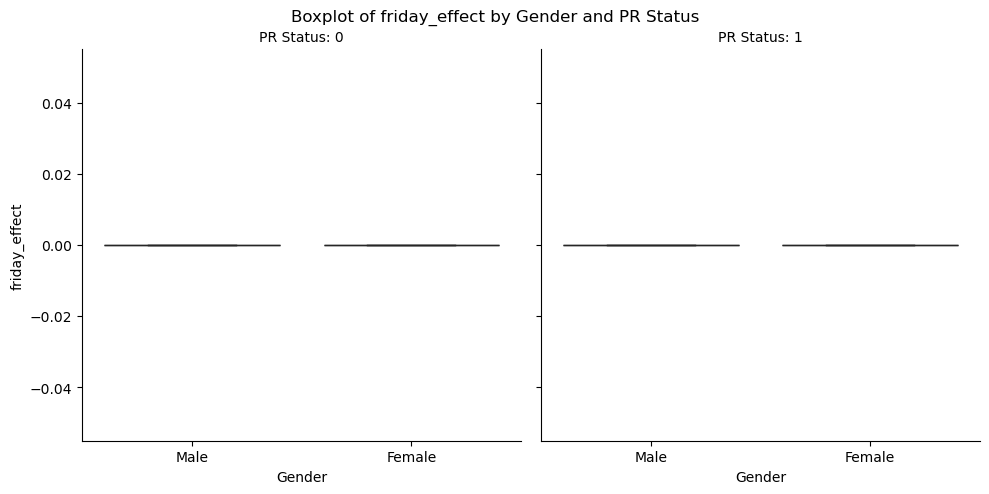

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


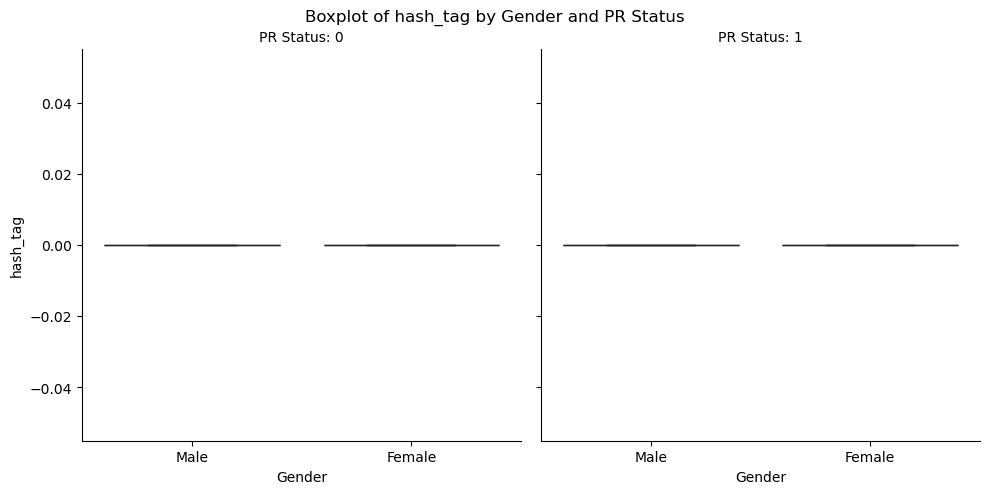

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


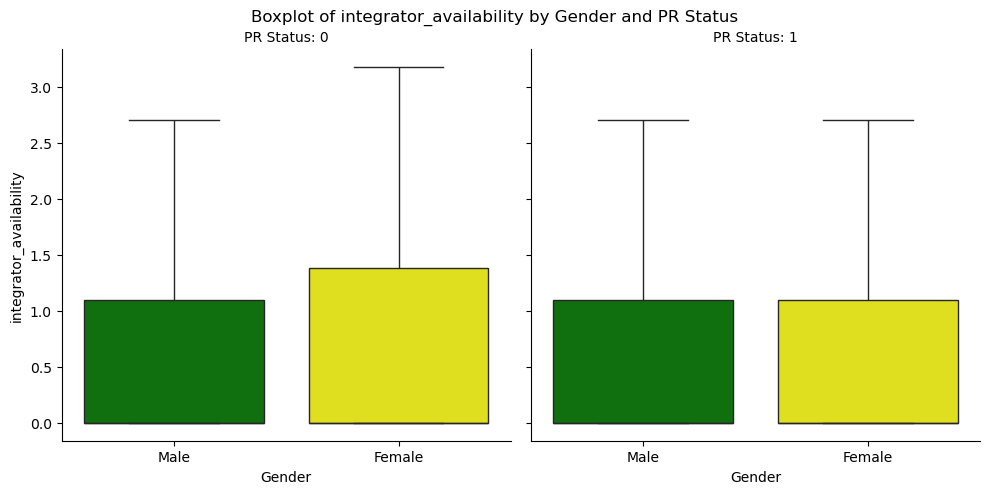

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


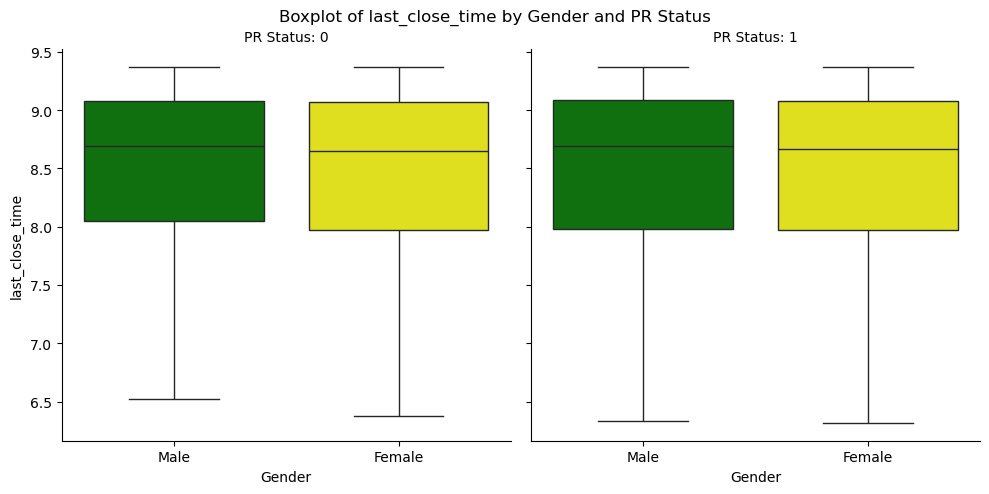

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


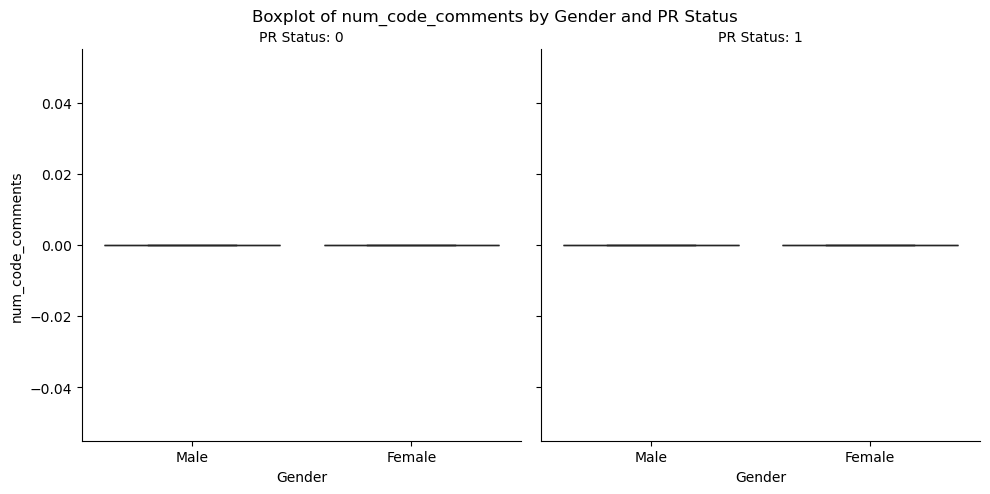

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


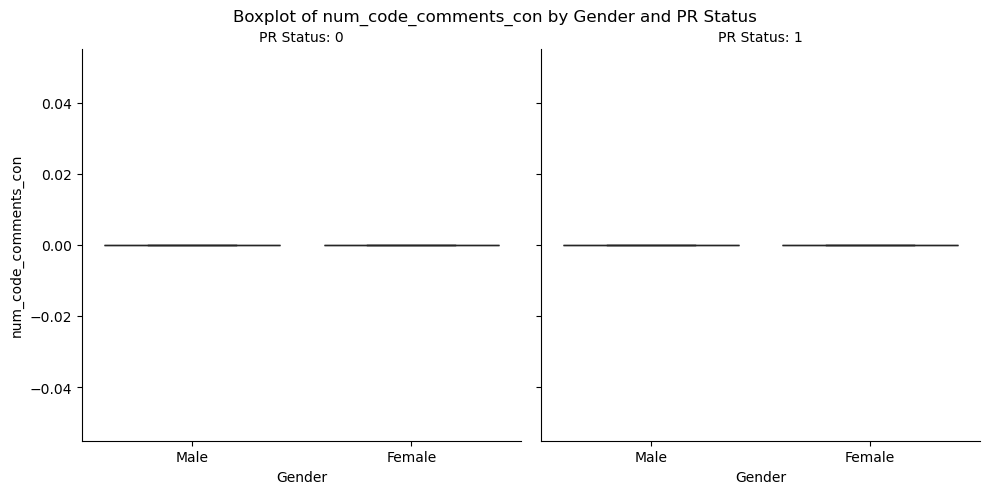

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


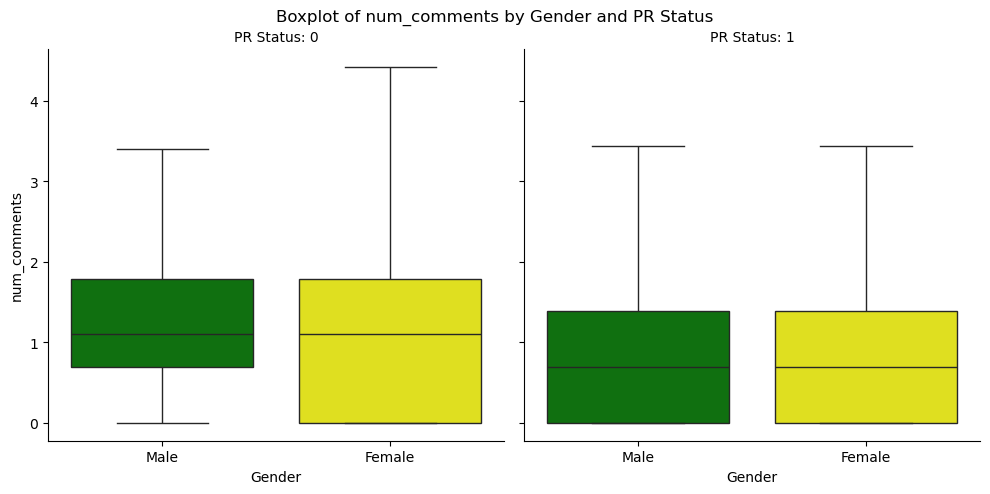

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


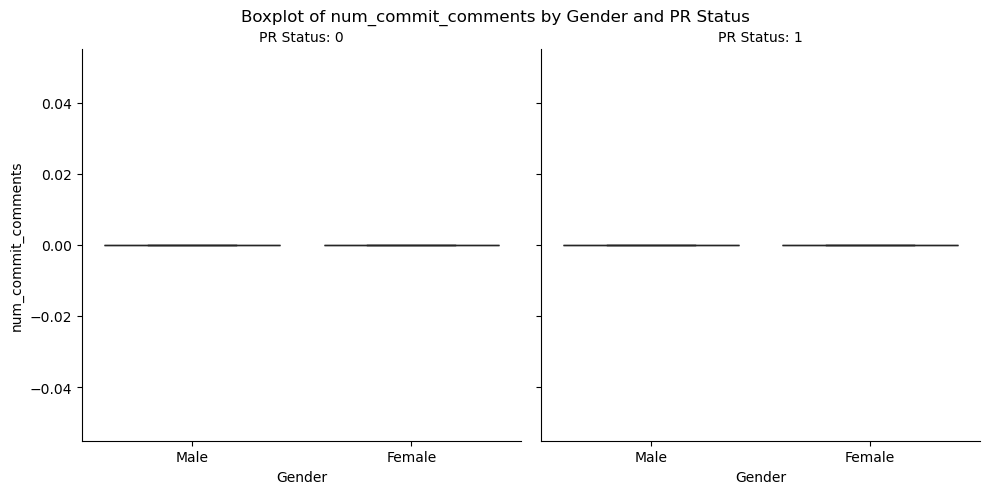

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


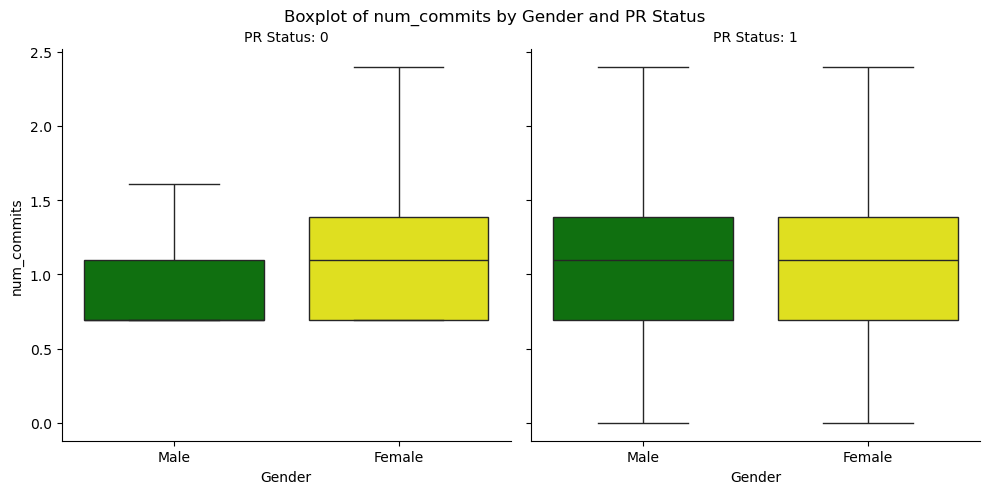

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


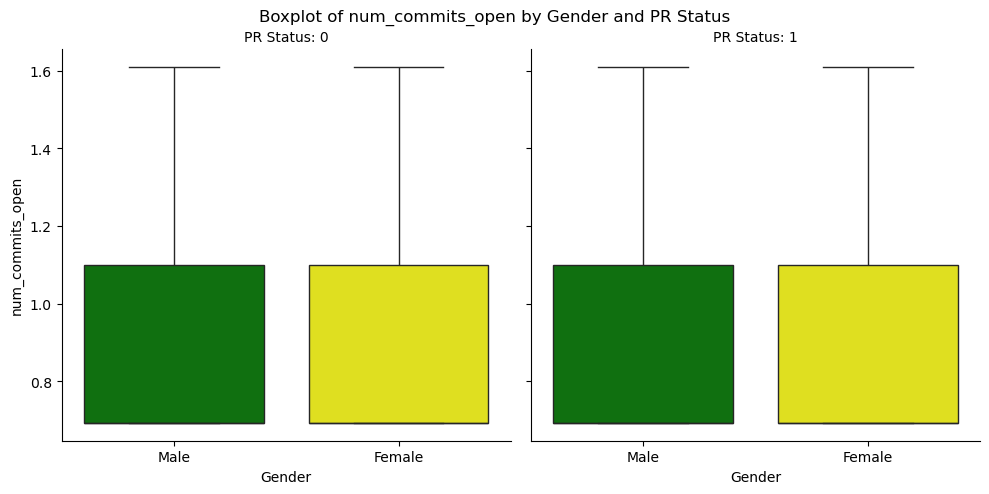

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


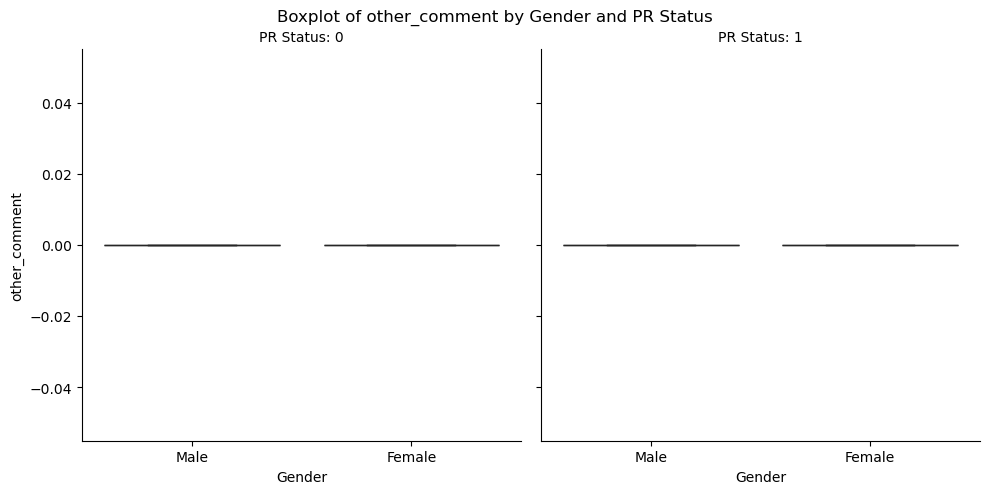

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


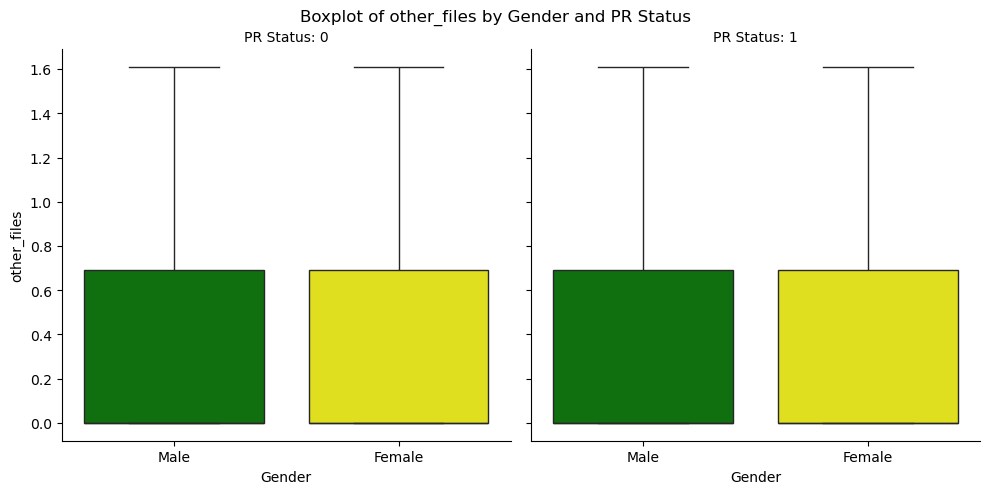

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


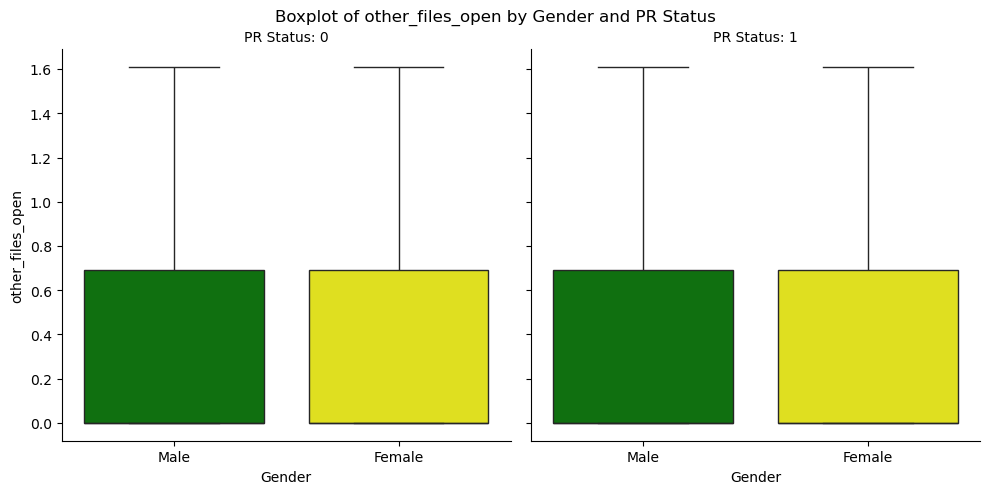

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


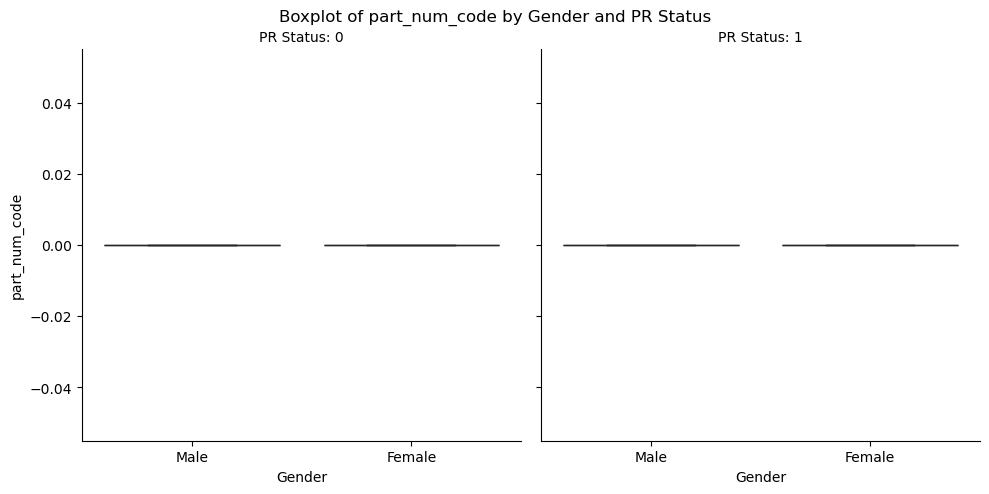

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


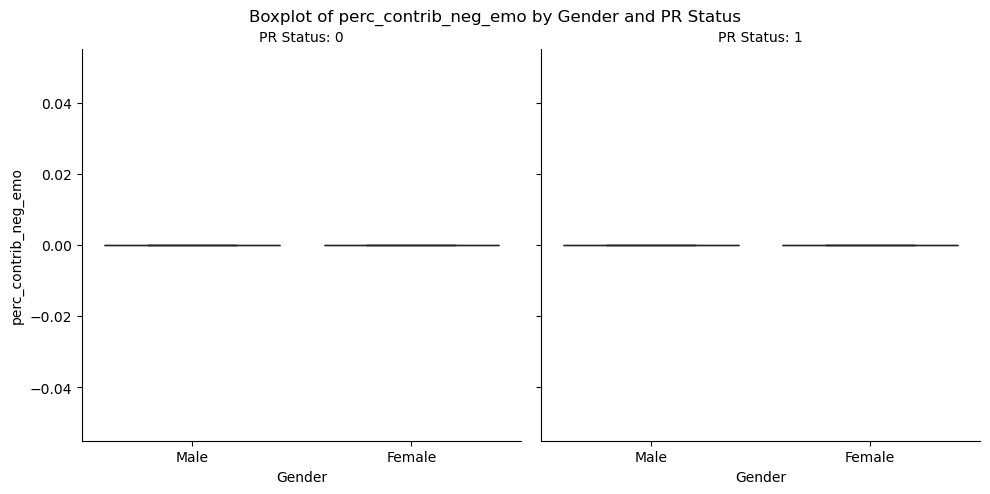

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


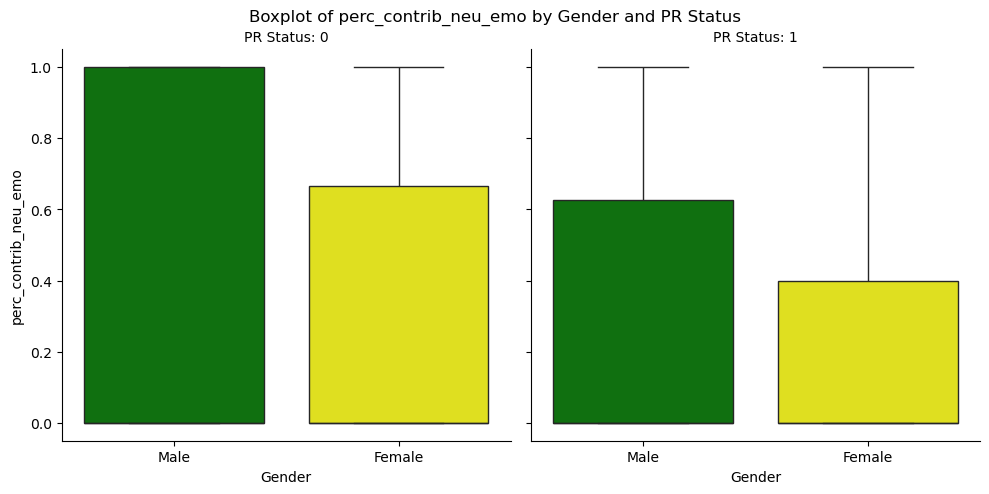

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


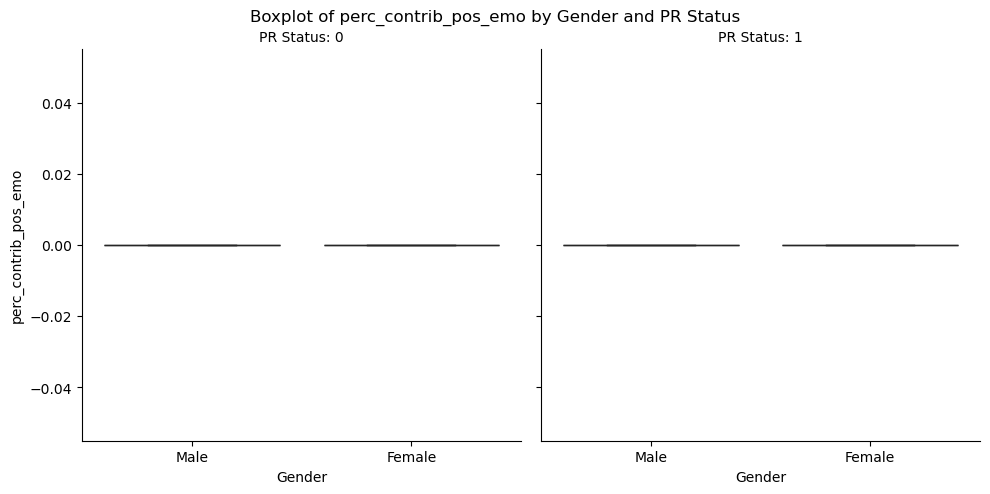

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


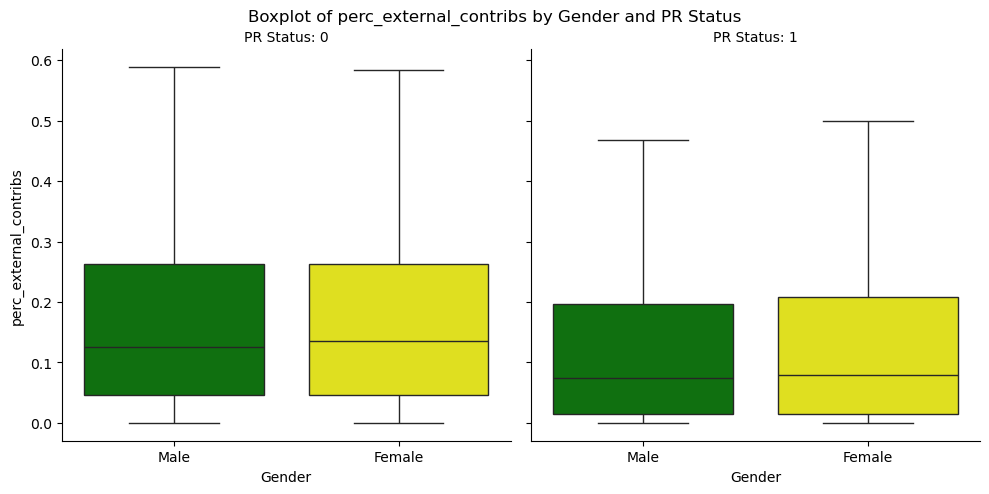

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


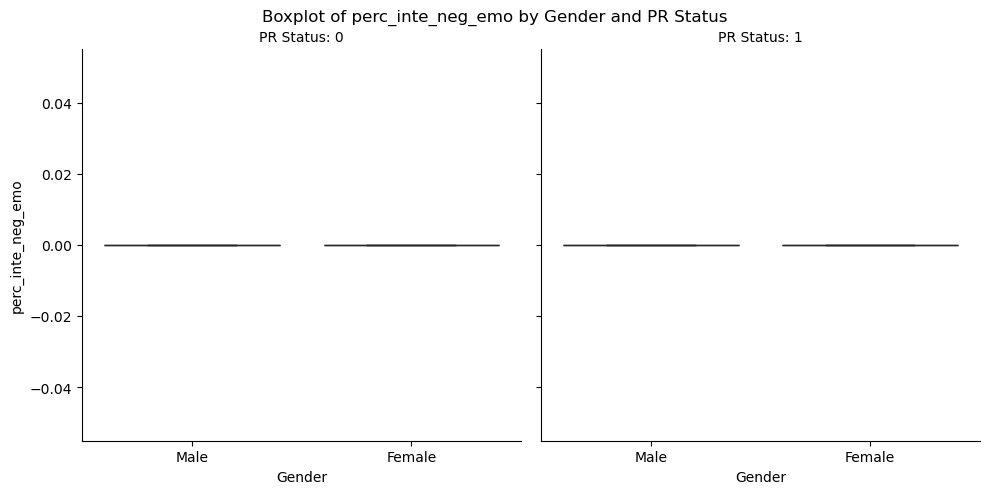

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


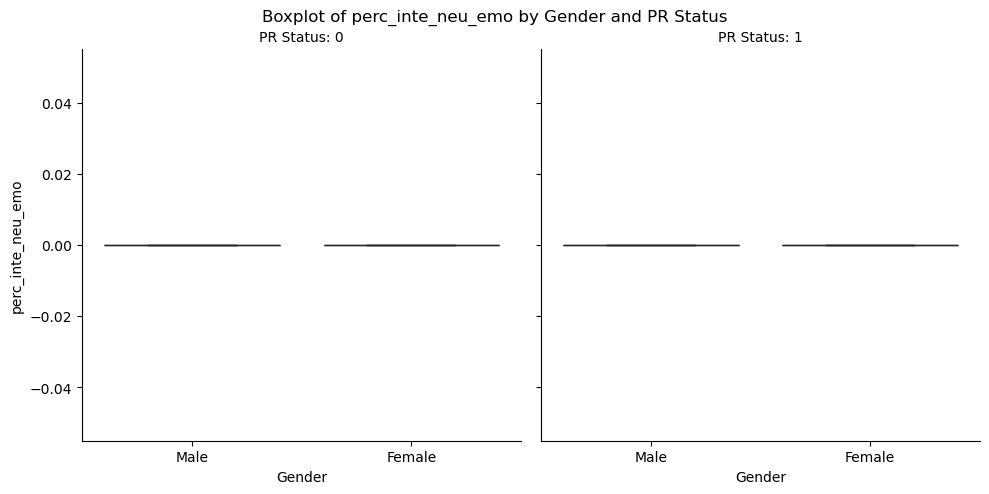

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


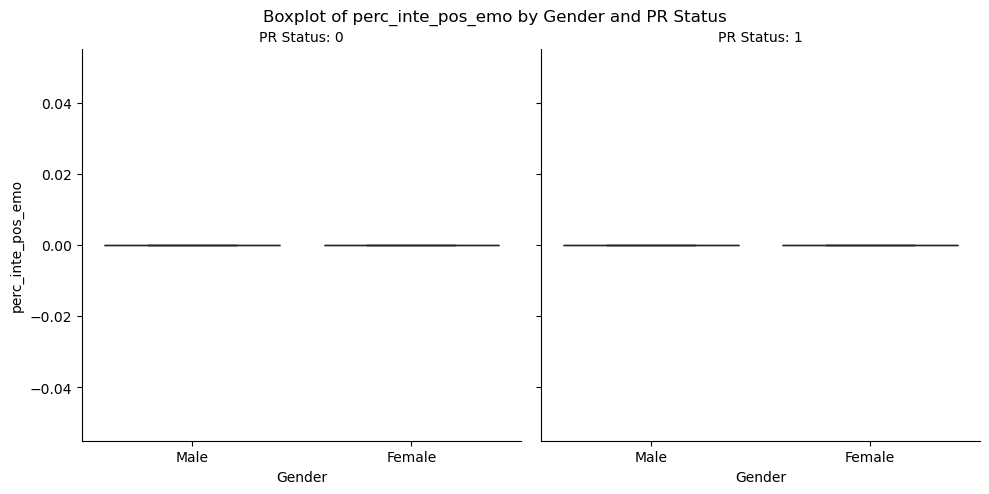

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


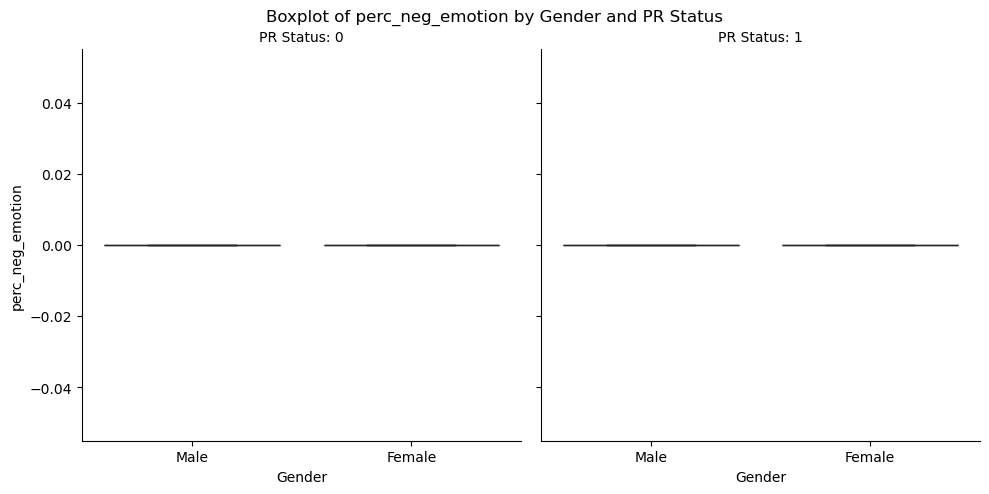

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


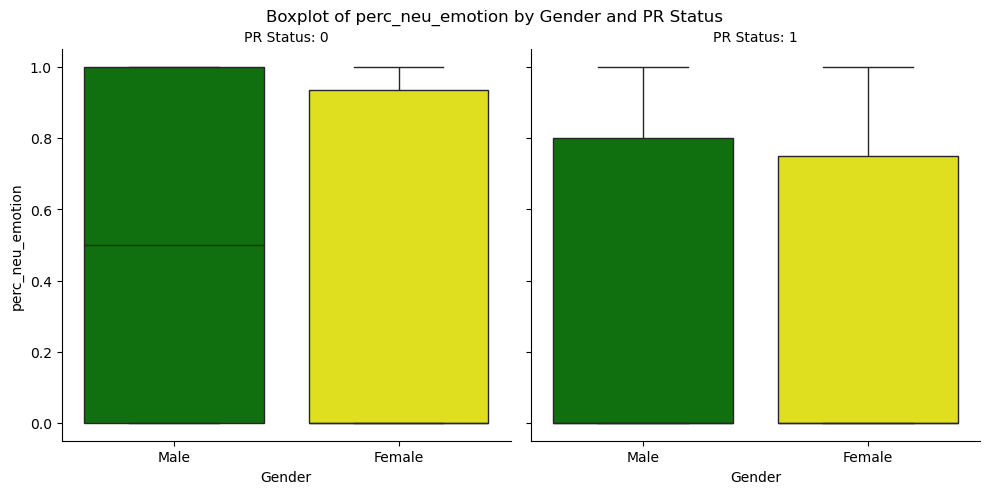

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


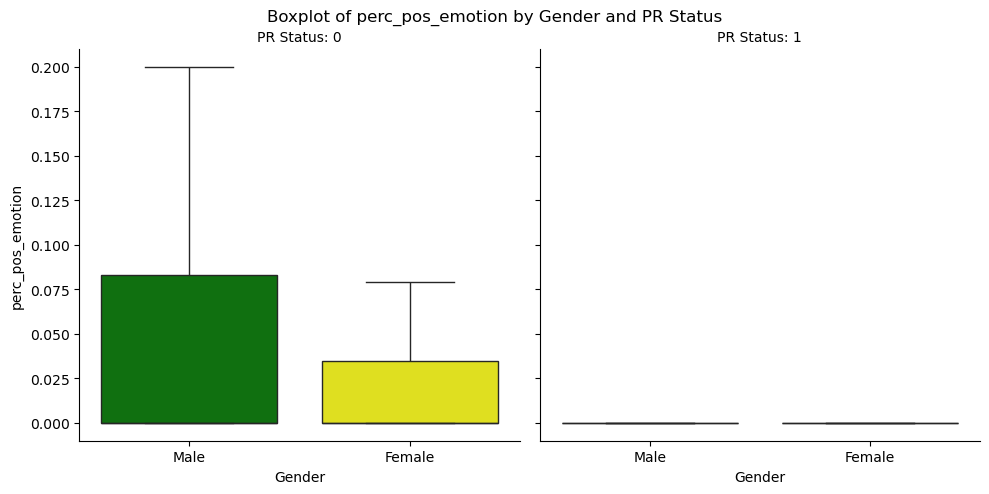

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


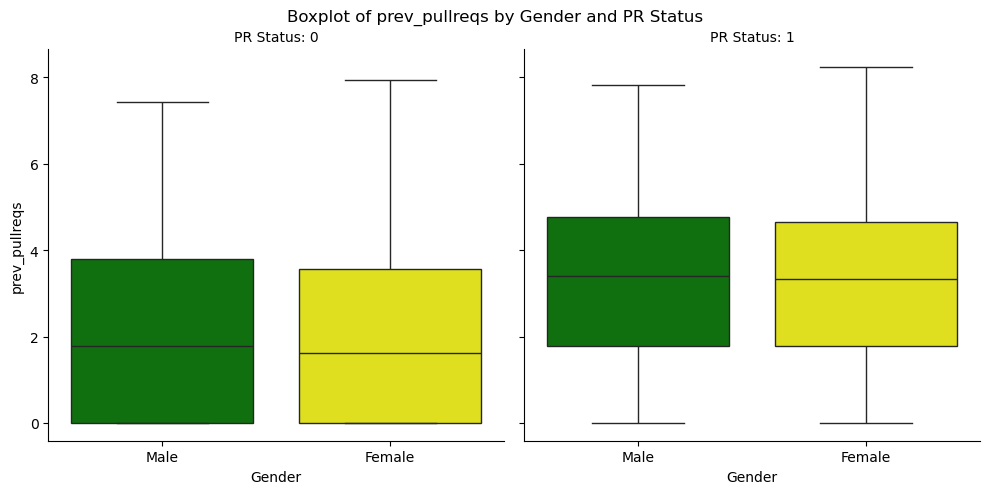

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


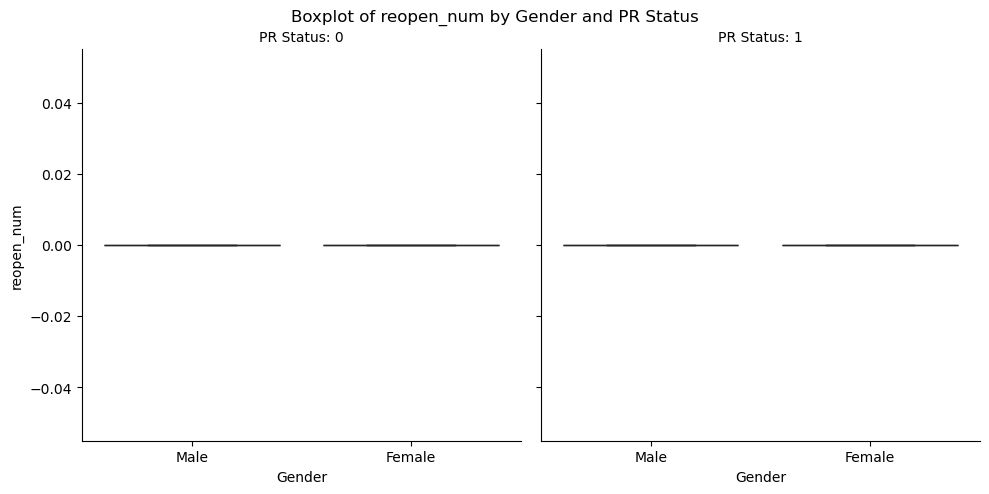

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


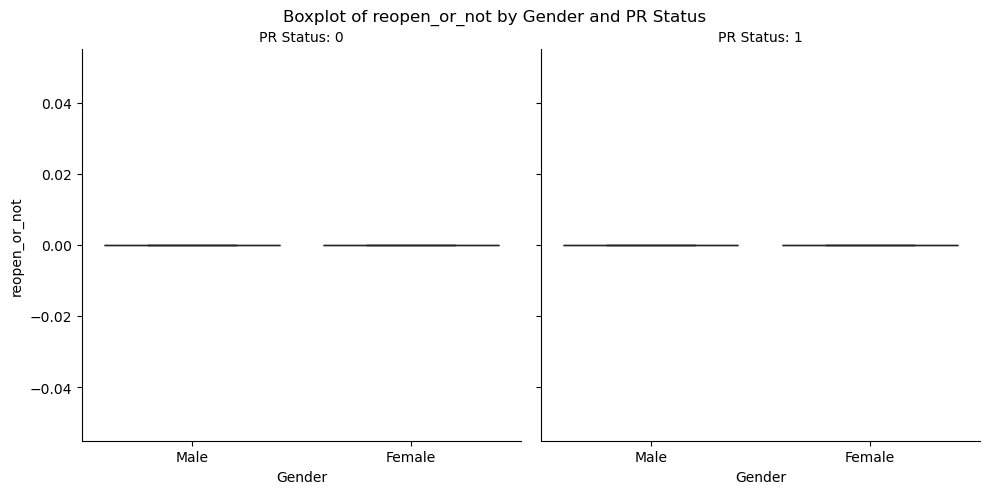

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


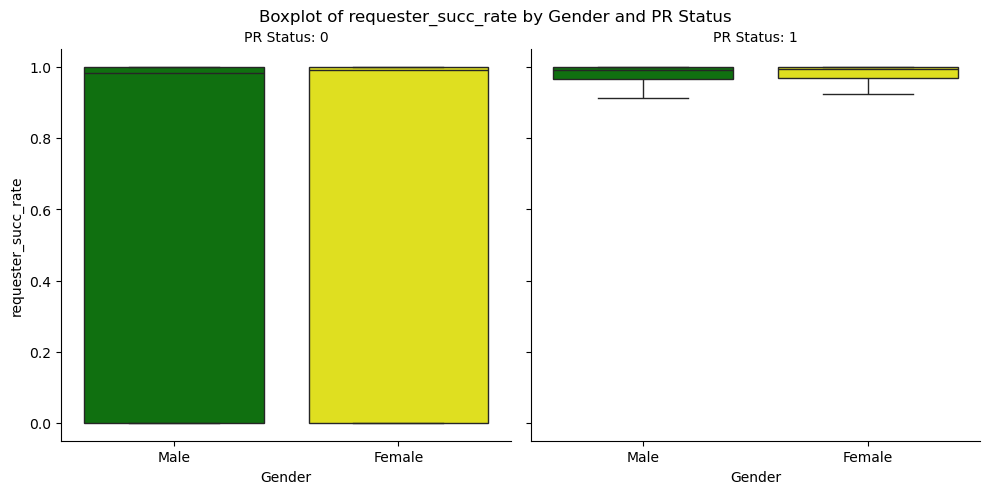

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


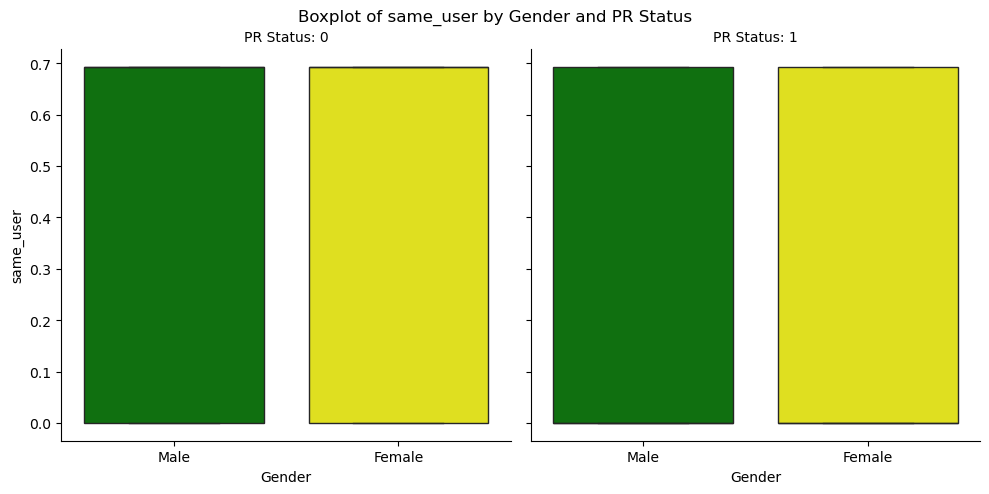

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


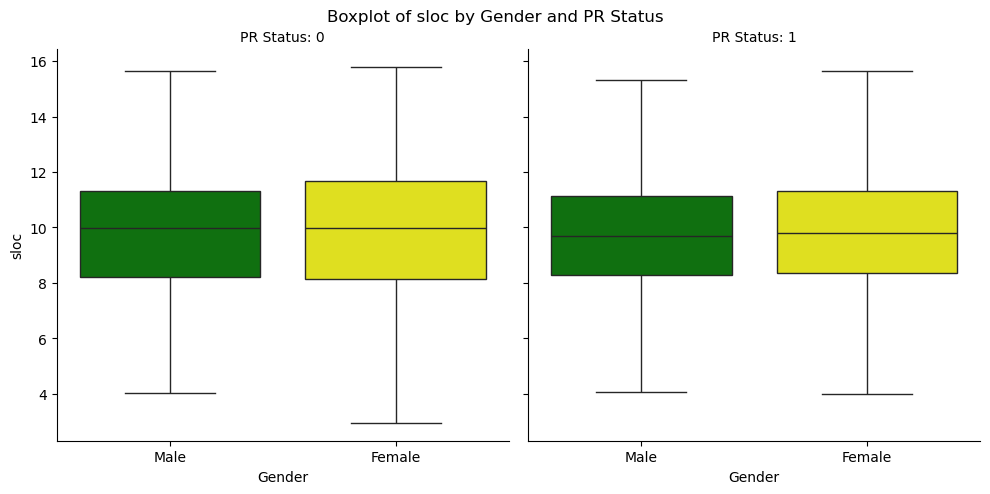

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


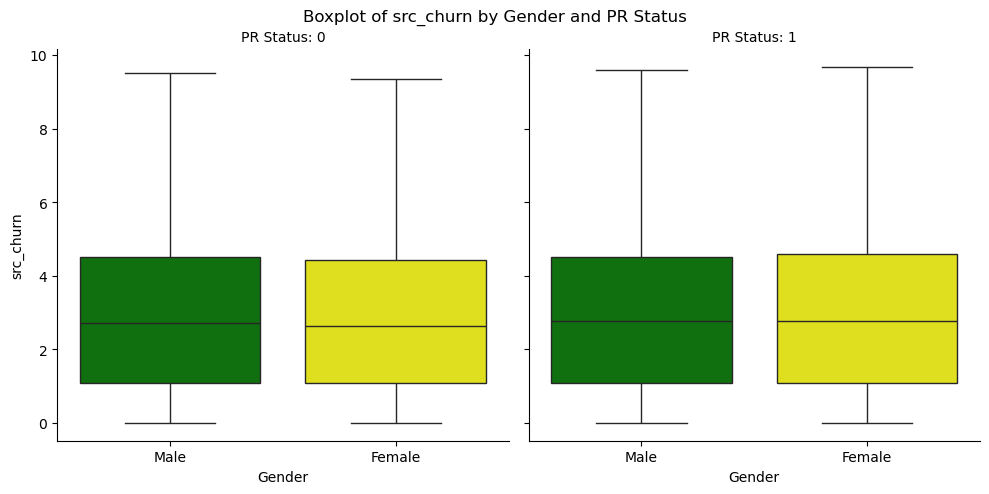

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


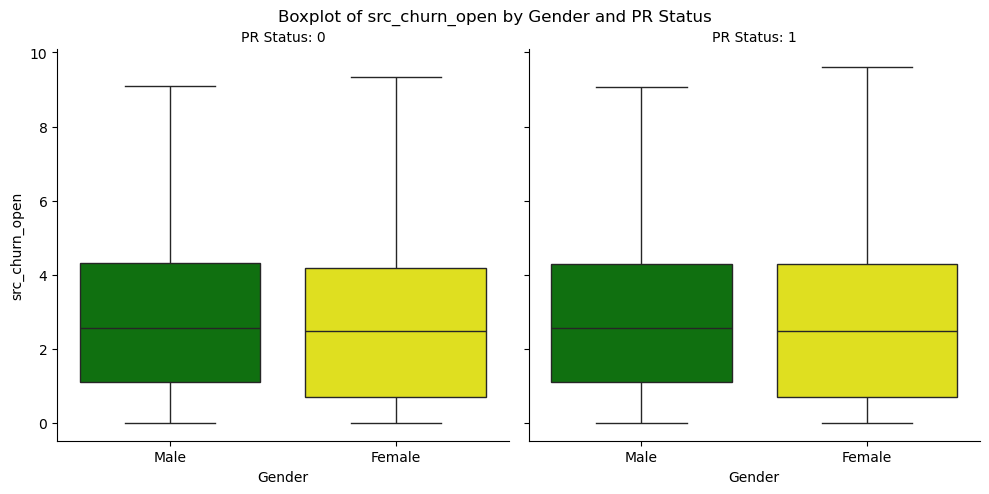

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


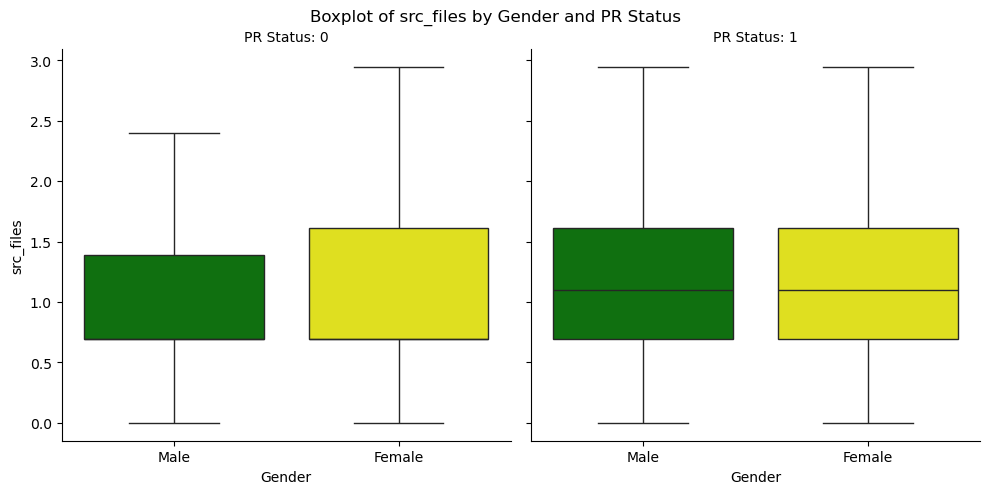

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


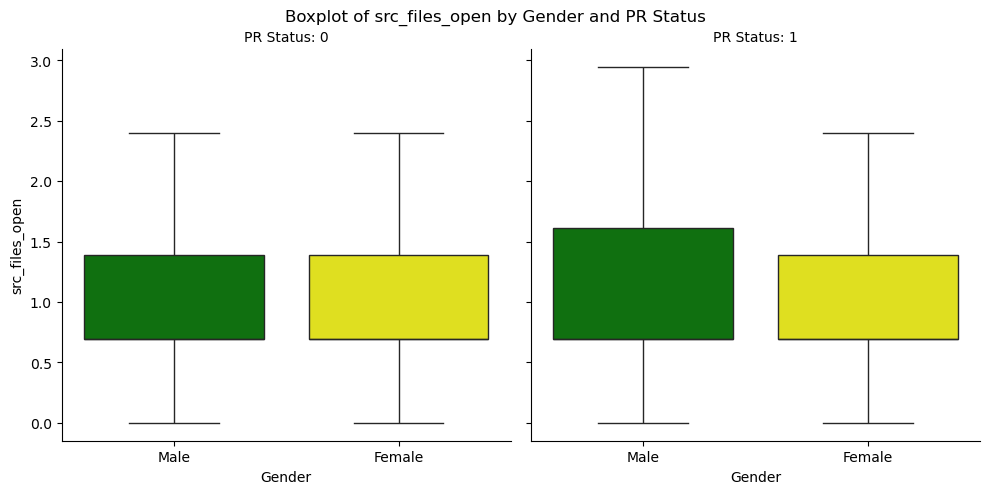

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


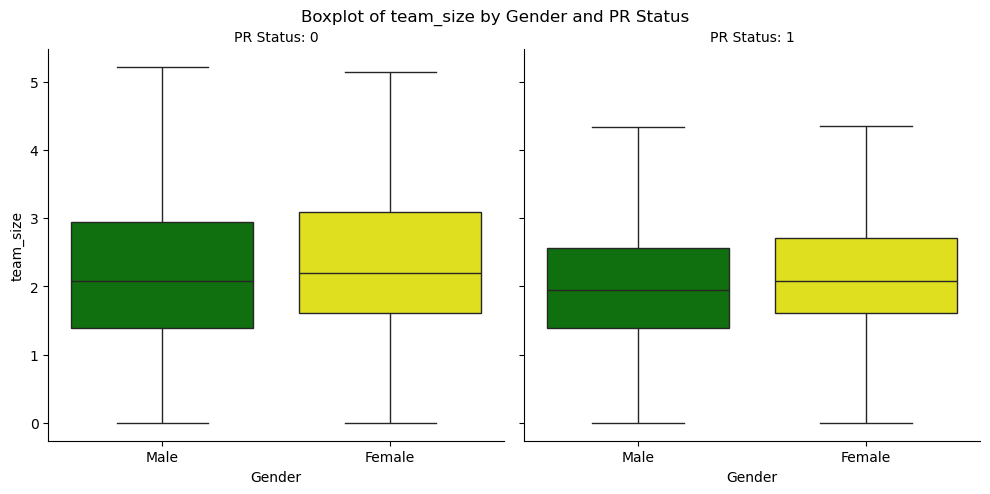

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


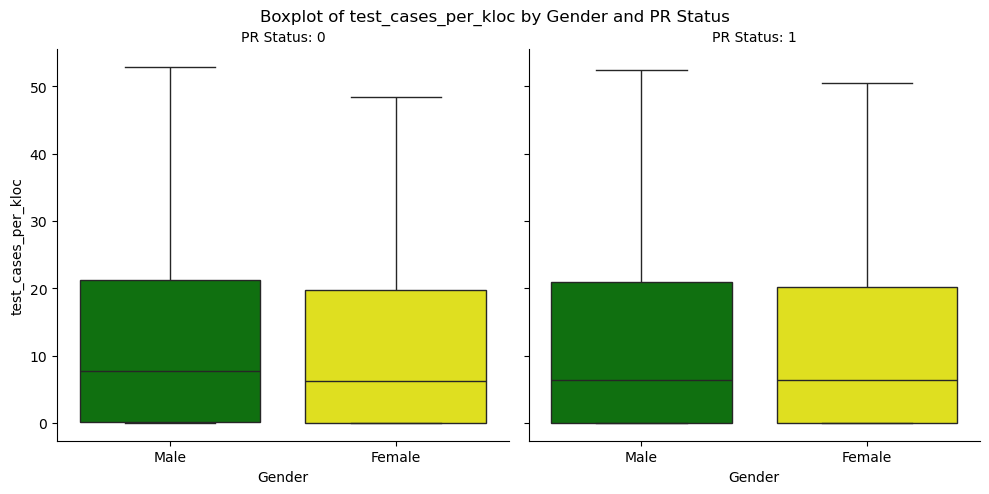

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


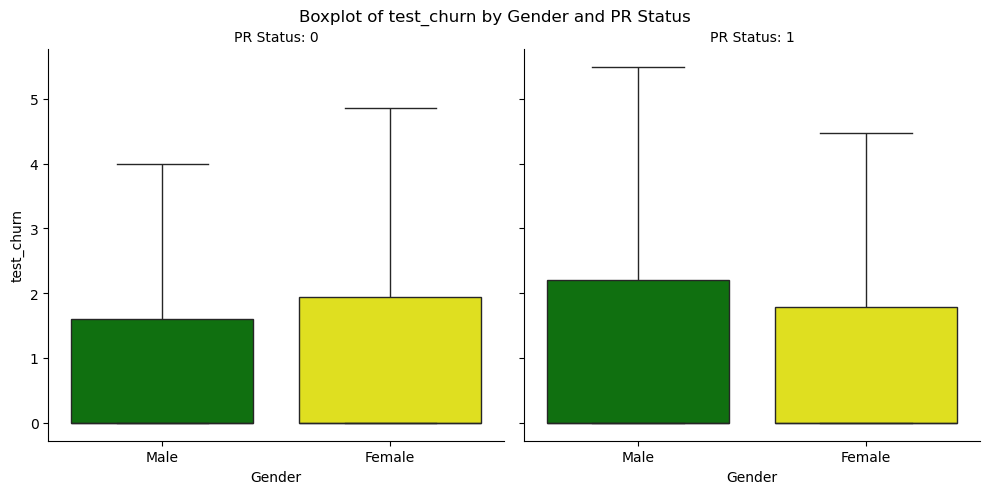

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


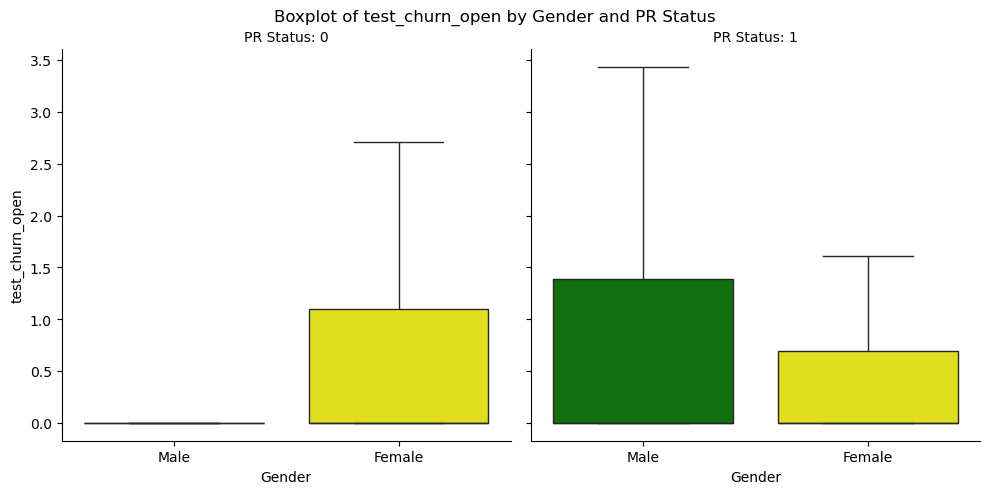

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


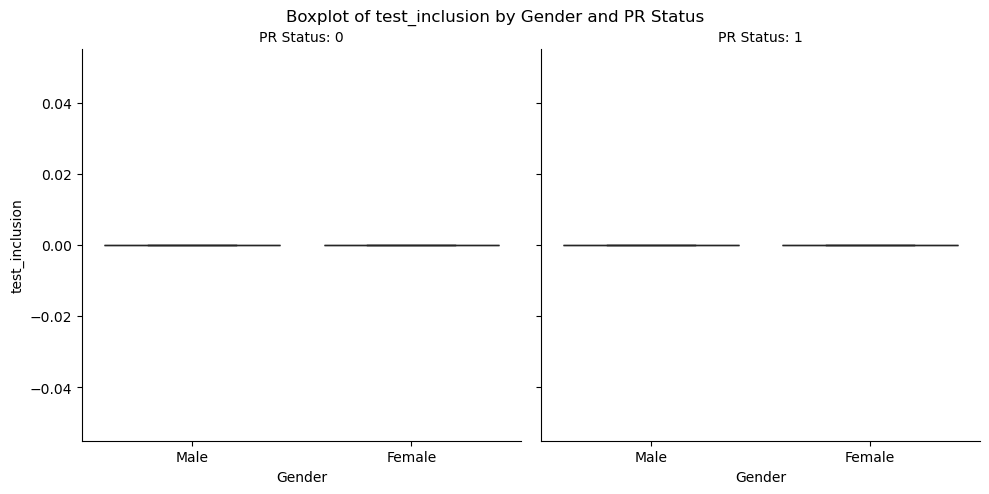

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


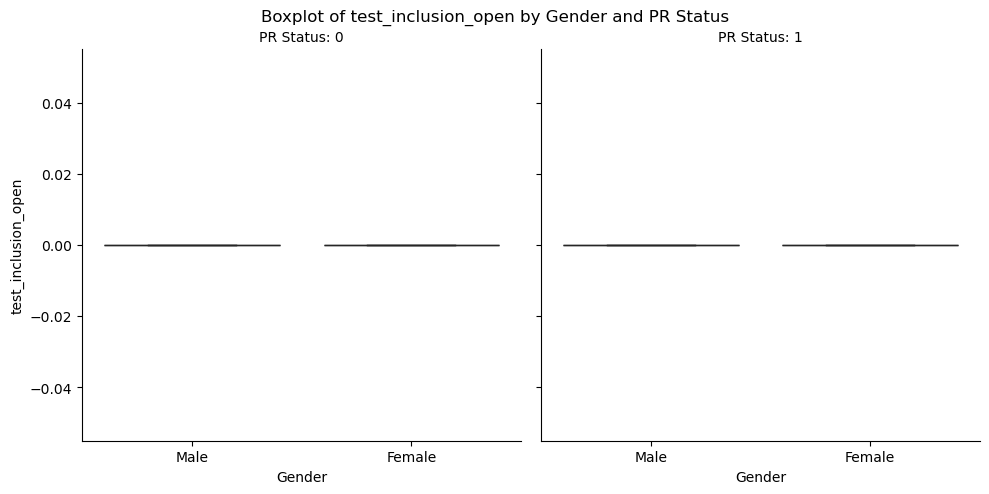

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


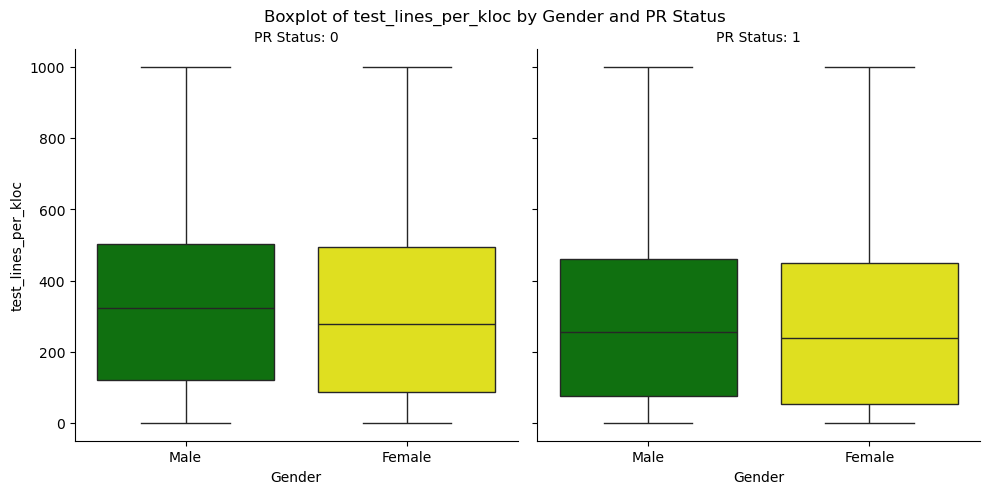

/var/folders/rf/5kzll5c90p3_69dtmj_p1fvm0000gn/T/ipykernel_7207/3230255368.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)


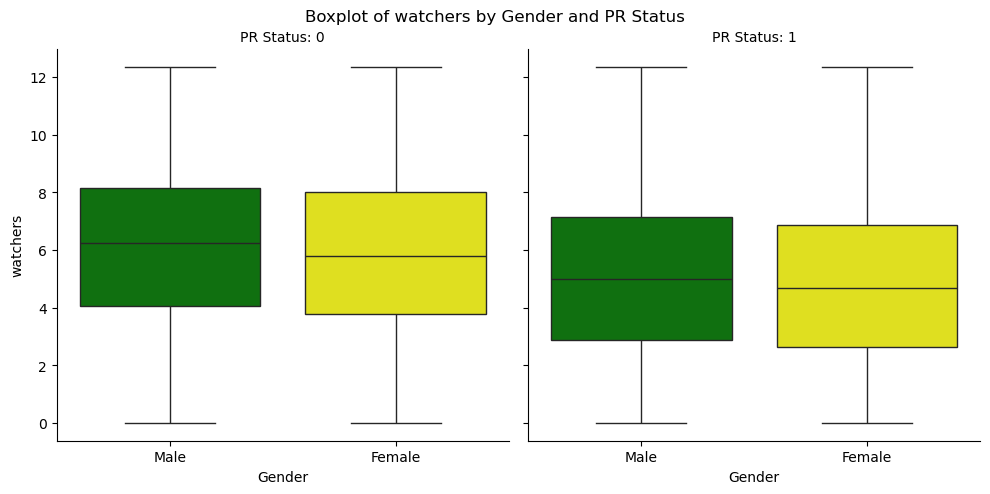

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'contrib_gender' to a categorical type with appropriate labels
data['contrib_gender'] = data['contrib_gender'].map({0: 'Male', 1: 'Female'})

features = data.columns.difference(['contrib_gender', 'merged_or_not'])

for feature in features:
    g = sns.catplot(x='contrib_gender', y=feature, col='merged_or_not', data=data, kind='box', palette=["green", "yellow"], showfliers=False)
    g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
    g.fig.suptitle(f'Boxplot of {feature} by Gender and PR Status')
    g.set_axis_labels('Gender', feature)
    g.set_titles('PR Status: {col_name}')
    plt.show()